# Real world data analysis for the simulator

This notebook outlines the definitions of each of the varibles that are to be plotted for experiment comparison with the simulator.

For each variable, there is a definition given, a calculation method, calculation steps, and the assumptions made about the variable that is measured or derived from the data.

A list of the variables is the following:

Variables:
- Ground speed
- Heading
- Engine RPM
- Steering angle
- Rudder angle
- Pitch angle
- Roll angle
- Yaw angle
- Pitch rate
- Roll rate
- Yaw rate
- Latitude
- Longitude
- Bearing
- Velocity
- Wind speed
- Wind direction
- Time
- Number of satellites
- HDOP
- PDOP
- VDOP
- X and y component of velocity

## Ground speed

**Variable: Ground Speed**
1. **Definition:** Ground speed is the speed at which the GPS module moves relative to the Earth's surface.



2. **Calculation Method:**
   - **Derived or Calculated:** Calculated using GPS speed data.
   - **Data Sources Used:** GPS data is used directly since the GPS module measures the speed of the vehicle relative to the Earth's surface.
3. **Calculation Steps:**
   - Data is read in from the 'SpeedMPH' column of the GPS data file.
   - Speed is converted to knots using a conversion factor of 1 mph = 0.868976 knots.
   - Apply any necessary filtering to remove outliers or erroneous readings

### Ground speed stretch goals
   - IMU Integration: If necessary, integrate IMU data to enhance ground speed accuracy by compensating for any GPS signal inconsistencies.
   - Component Analysis: Split ground speed into x (east-west) and y (north-south) components to facilitate vector-based analyses and comparisons with simulated data.


## Heading

**Variable: Ground Speed**
1. **Definition:** Ground speed is the speed at which the GPS module moves relative to the Earth's surface.



2. **Calculation Method:**
   - **Derived or Calculated:** Calculated using GPS speed data.
   - **Data Sources Used:** GPS data is used directly since the GPS module measures the speed of the vehicle relative to the Earth's surface.
3. **Calculation Steps:**
   - Data is read in from the 'SpeedMPH' column of the GPS data file.
   - Speed is converted to knots using a conversion factor of 1 mph = 0.868976 knots.
   - If necessary, integrate IMU data for enhanced accuracy.

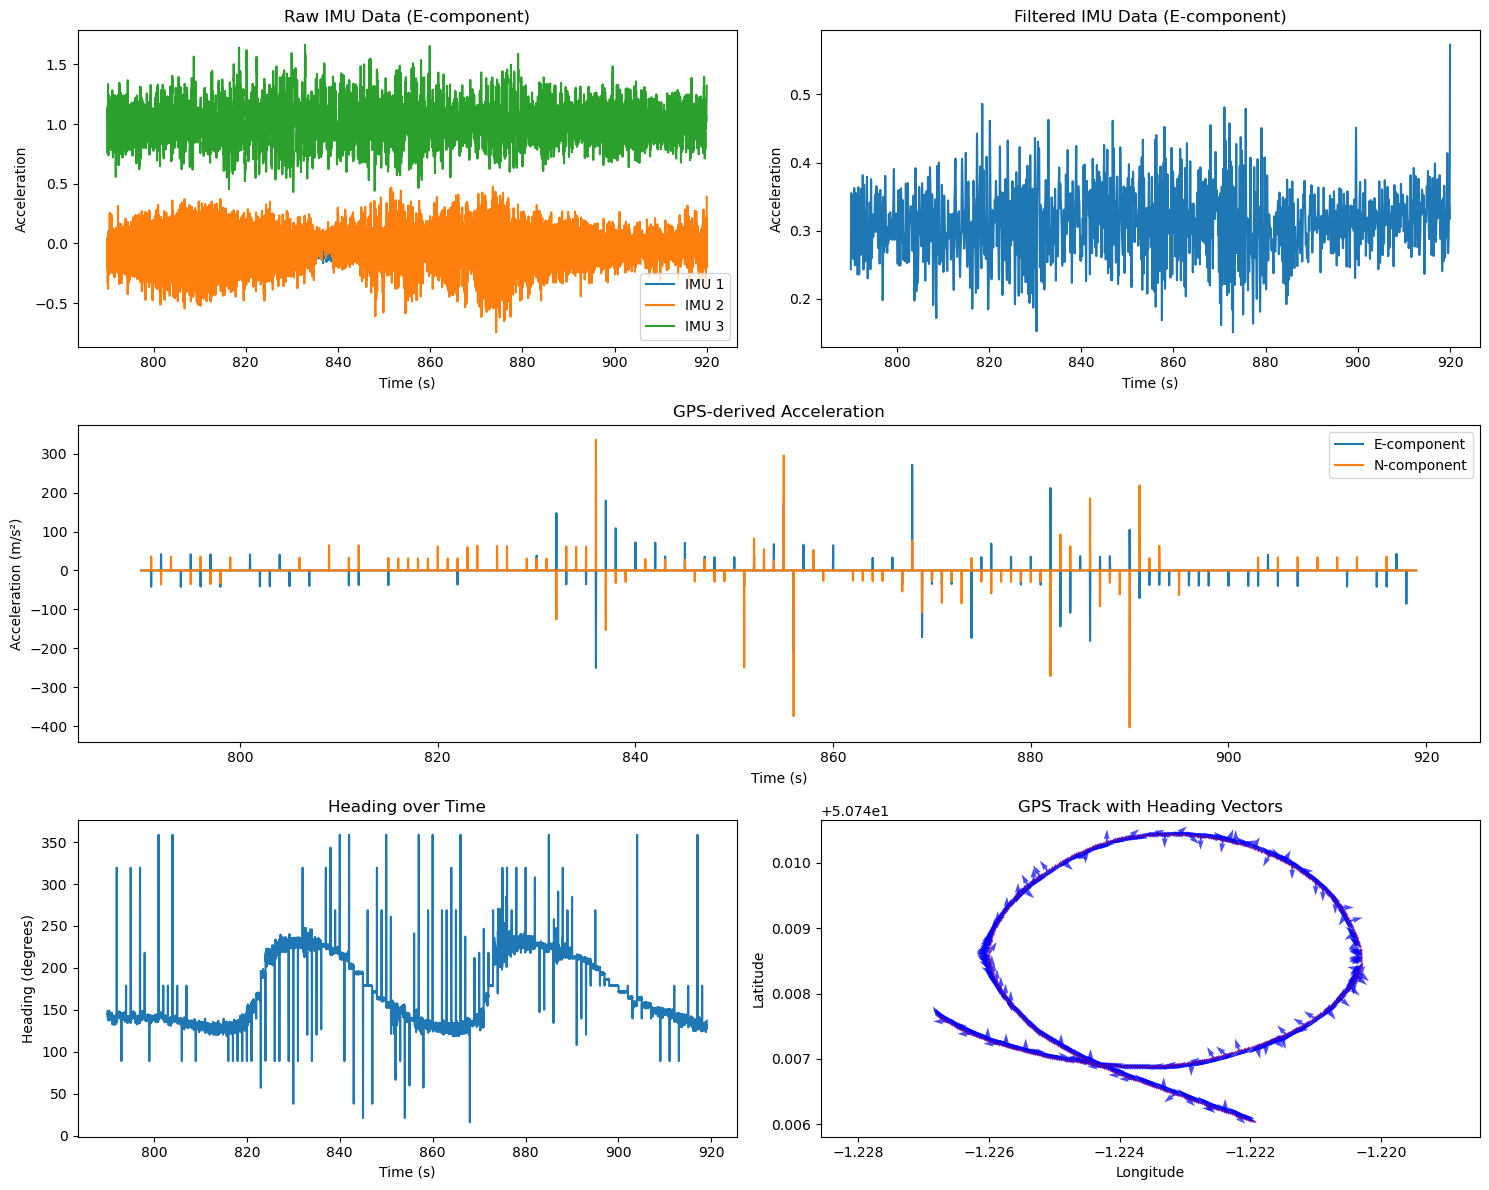

In [8]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# === Transformation Functions === (unchanged)
def transform_accel_imu3(x, y, z):
    E = -z
    N = y 
    U = x
    return E, N, U

def transform_accel_imu4(x, y, z):
    E = y
    N = z
    U = x 
    return E, N, U

def transform_accel_wb(x, y, z):
    E = z
    N = -y
    U = x
    return E, N, U

def resample_data(time, data, target_freq=100):
    """Resample data to target frequency"""
    duration = time[-1] - time[0]
    num_samples = int(duration * target_freq)
    new_time = np.linspace(time[0], time[-1], num_samples)
    
    # Create interpolation function for each column
    if data.ndim == 1:
        interp_func = interp1d(time, data, kind='linear', axis=0)
        resampled_data = interp_func(new_time)
    else:
        resampled_data = np.zeros((num_samples, data.shape[1]))
        for i in range(data.shape[1]):
            interp_func = interp1d(time, data[:, i], kind='linear', axis=0)
            resampled_data[:, i] = interp_func(new_time)
    
    return new_time, resampled_data

def read_imu_data(base_path, test_name):
    """Read and transform IMU data from all sensors"""
    sensors = ['Sensor_3', 'Sensor_4', 'Sensor_wb']
    sensor_data = []
    min_time = float('inf')
    max_time = float('-inf')
    
    # First pass: determine common time range
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        time = accel_df['time_from_sync'].values
        min_time = min(min_time, time[0])
        max_time = max(max_time, time[-1])
    
    # Create common time array
    target_freq = 100
    num_samples = int((max_time - min_time) * target_freq)
    common_time = np.linspace(min_time, max_time, num_samples)
    
    # Second pass: resample all sensors to common time
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        
        # Transform accelerations based on sensor
        x, y, z = accel_df['x'], accel_df['y'], accel_df['z']
        if sensor == 'Sensor_3':
            E, N, U = transform_accel_imu3(x, y, z)
        elif sensor == 'Sensor_4':
            E, N, U = transform_accel_imu4(x, y, z)
        else:  # Sensor_wb
            E, N, U = transform_accel_wb(x, y, z)
            
        current_data = np.column_stack((E, N, U))
        time = accel_df['time_from_sync'].values
        
        # Resample to common time array
        resampled_data = np.zeros((len(common_time), 3))
        for i in range(3):
            interp_func = interp1d(time, current_data[:, i], kind='linear', bounds_error=False, fill_value='extrapolate')
            resampled_data[:, i] = interp_func(common_time)
        
        sensor_data.append(resampled_data)

    # Stack all sensor data into a 3D array
    combined_data = np.stack(sensor_data, axis=0)
    return {'time': common_time, 'accel': combined_data}


def preprocess_imu(accel_data):
    # Average across 3 IMUs
    combined_accel = np.mean(accel_data, axis=0)
    # Apply low-pass filter to reduce noise
    b, a = butter(4, 0.1)
    filtered_accel = filtfilt(b, a, combined_accel, axis=0)
    return filtered_accel

# === GPS Functions === (unchanged)
def gps_acceleration(lat, lng, time):
    R = 6371000  # Earth radius in meters
    
    # Convert to meters
    x = R * np.cos(np.radians(lat)) * np.cos(np.radians(lng))
    y = R * np.cos(np.radians(lat)) * np.sin(np.radians(lng))
    
    # Calculate velocity and acceleration
    dx = np.gradient(x, time)
    dy = np.gradient(y, time)
    ax = np.gradient(dx, time)
    ay = np.gradient(dy, time)
    
    return np.column_stack((ax, ay))

def read_gps_data(base_path, test_name):
    """Read GPS data"""
    gps_path = os.path.join(base_path, test_name, 'GPS', f'GPS_{test_name}.csv')
    gps_df = pd.read_csv(gps_path)
    return {
        'lat': gps_df['Lat'].values,
        'lng': gps_df['Lng'].values,
        'time_from_sync': gps_df['time_from_sync'].values
    }

def compute_heading(imu_accel, gps_accel):
    heading = np.arctan2(gps_accel[:, 1], gps_accel[:, 0])
    heading_deg = np.degrees(heading) % 360
    return heading_deg

def calculate_heading(base_path, test_name, window_size=5):
    # Read data
    imu_data = read_imu_data(base_path, test_name)
    gps_data = read_gps_data(base_path, test_name)

    # Process pipeline
    imu_accel = preprocess_imu(imu_data['accel'])
    gps_acc = gps_acceleration(gps_data['lat'], gps_data['lng'], gps_data['time_from_sync'])
    heading = compute_heading(imu_accel, gps_acc)

    return heading

def plot_data(base_path, test_name):
    # Read data
    imu_data = read_imu_data(base_path, test_name)
    gps_data = read_gps_data(base_path, test_name)
    
    # Resample GPS data to match IMU time
    gps_time, gps_lat = resample_data(gps_data['time_from_sync'], gps_data['lat'])
    _, gps_lng = resample_data(gps_data['time_from_sync'], gps_data['lng'])
    gps_acc = gps_acceleration(gps_lat, gps_lng, gps_time)
    heading = compute_heading(preprocess_imu(imu_data['accel']), gps_acc)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 12))
    gs = plt.GridSpec(3, 2)

    # 1. Raw IMU Data
    ax1 = fig.add_subplot(gs[0, 0])
    for i in range(3):
        ax1.plot(imu_data['time'], imu_data['accel'][i, :, 0], label=f'IMU {i+1}')
    ax1.set_title('Raw IMU Data (E-component)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Acceleration')
    ax1.legend()

    # 2. Filtered IMU Data
    ax2 = fig.add_subplot(gs[0, 1])
    filtered_imu = preprocess_imu(imu_data['accel'])
    ax2.plot(imu_data['time'], filtered_imu[:, 0])
    ax2.set_title('Filtered IMU Data (E-component)') 
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Acceleration')

    # 3. GPS Acceleration
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(gps_time, gps_acc[:, 0], label='E-component')
    ax3.plot(gps_time, gps_acc[:, 1], label='N-component')
    ax3.set_title('GPS-derived Acceleration')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.legend()

    # 4. Heading over time
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(gps_time, heading)
    ax4.set_title('Heading over Time')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Heading (degrees)')

    # 5. Quiver plot
    ax5 = fig.add_subplot(gs[2, 1])
    
    # Sample every nth point for clearer visualization
    n = 20
    heading_rad = np.radians(heading[::n])
    u = np.cos(heading_rad)
    v = np.sin(heading_rad)

    ax5.quiver(gps_lng[::n], gps_lat[::n], u, v,
               scale=50, width=0.003, color='blue', alpha=0.7)
    ax5.plot(gps_lng, gps_lat, 'r-', alpha=0.3)
    ax5.set_title('GPS Track with Heading Vectors')
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Latitude')
    ax5.axis('equal')

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    base_path = '../'
    test_name = '007_Fast_stbd_turn_1'
    plot_data(base_path, test_name)


In [10]:
import os
import json
from pathlib import Path

def get_file_contents(filepath, max_lines=5):
    """Get the first n lines of a file as a string."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()[:max_lines]
            return ''.join(lines)
    except Exception as e:
        return f"Error reading file: {str(e)}"

def scan_directory(path='.'):
    """Recursively scan directory and return structure as dictionary."""
    path = Path(path)
    result = {
        'name': path.name,
        'type': 'directory',
        'contents': []
    }
    
    try:
        # Get all items in directory
        items = list(path.iterdir())
        
        # Process each item
        for item in sorted(items):
            if item.is_dir():
                # Recursively scan subdirectories
                result['contents'].append(scan_directory(item))
            else:
                # Add file with preview
                result['contents'].append({
                    'name': item.name,
                    'type': 'file',
                    'preview': get_file_contents(item, max_lines=5)
                })
    except Exception as e:
        result['error'] = str(e)
    
    return result

def save_directory_structure(path='.', output_file='directory_structure.json'):
    """Scan directory and save structure to JSON file."""
    structure = scan_directory(path)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(structure, f, indent=2)
    
    print(f"Directory structure saved to {output_file}")

# Execute the scan and save
save_directory_structure()


Directory structure saved to directory_structure.json


In [11]:
import json, glob, pathlib, pandas as pd, numpy as np
import matplotlib.pyplot as plt

# ---------- 1. load sensor orientation info ----------
with open("sensor_orientations.json") as f:        # rename if needed
    orient = {d["device_name"]: d for d in json.load(f)}

# ---------- 2. GPS ----------
gps_path = sorted(pathlib.Path("GPS").glob("GPS_*_Fast_stbd_turn_1.csv"))[0]
gps = pd.read_csv(gps_path, parse_dates=["Time"])
gps["t_sync"] = gps["time_from_sync"]           # shortcut

# ---------- 3. IMUs ----------
imu_frames = []
for imu_dir in pathlib.Path("IMU").iterdir():
    dev = imu_dir.name.lower()                  # e.g. sensor_3
    accel   = pd.read_csv(next(imu_dir.glob("accel_*.csv")))
    angles  = pd.read_csv(next(imu_dir.glob("angle_*.csv")))
    df = accel.merge(angles[["t","z","time_from_sync"]], on=["t","time_from_sync"], suffixes=("_acc","_ang"))
    df["acc_mag_g"] = np.sqrt(df[["x_acc","y_acc","z_acc"]].pow(2).sum(axis=1))
    df["device"] = dev
    df["location"] = orient[dev]["location"]
    df["t_sync"] = df["time_from_sync"]
    imu_frames.append(df[["t_sync","acc_mag_g","z","device","location"]])

imus = pd.concat(imu_frames).sort_values("t_sync")

# ---------- 4. plot ----------
fig, (ax_speed, ax_acc, ax_ang, ax_map) = plt.subplots(4, 1, figsize=(10,12),
                                                      sharex=True,
                                                      gridspec_kw={"height_ratios":[1,1,1,1.2]})
# speed
ax_speed.plot(gps["t_sync"], gps["SpeedKPH"])
ax_speed.set_ylabel("Speed (km/h)"); ax_speed.set_title("GPS speed")

# acceleration magnitude
for dev, g in imus.groupby("device"):
    ax_acc.plot(g["t_sync"], g["acc_mag_g"], label=f"{dev} ({g['location'].iloc[0]})")
ax_acc.set_ylabel("|a| (g)"); ax_acc.set_title("IMU acceleration magnitude")
ax_acc.legend(loc="upper right", fontsize=8)

# yaw-like angle
for dev, g in imus.groupby("device"):
    ax_ang.plot(g["t_sync"], g["z"], label=dev)
ax_ang.set_ylabel("z-angle (°)"); ax_ang.set_title("IMU raw z-angle")

# ground track inset
ax_map.plot(gps["Lng"], gps["Lat"])
ax_map.set_xlabel("Longitude"); ax_map.set_ylabel("Latitude"); ax_map.set_aspect("equal")
ax_map.set_title("Ground track")

plt.tight_layout()
plt.show()


KeyError: "['x_acc', 'y_acc'] not in index"

In [3]:
# Import necessary libraries
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, State
import dash_bootstrap_components as dbc
import os
import json

# --- Configuration ---

# Define the base directory where the experiment data is located
# IMPORTANT: Change this to the actual path of your experiment folder
BASE_DIR = '.' # Assuming the script runs in the parent directory of GPS and IMU folders

# Experiment identifier (from file names)
EXPERIMENT_ID = "007_Fast_stbd_turn_1"

# --- Data Loading Functions ---

def load_sensor_orientations(base_dir):
    """Loads sensor orientations from sensor_orientations.json."""
    orientations_file_path = os.path.join(base_dir, "sensor_orientations.json")
    default_orientations = {}
    try:
        with open(orientations_file_path, 'r') as f:
            orientations_list = json.load(f)
            return {item['device_name'].lower(): item for item in orientations_list}
    except FileNotFoundError:
        print(f"Warning: 'sensor_orientations.json' not found in {base_dir}. Using empty orientations.")
        return default_orientations
    except json.JSONDecodeError:
        print(f"Warning: Error decoding 'sensor_orientations.json'. Using empty orientations.")
        return default_orientations
    except Exception as e:
        print(f"An unexpected error occurred while loading sensor orientations: {e}. Using empty orientations.")
        return default_orientations

def find_file(base_path, experiment_id, prefix=None):
    """Finds the first file in a directory matching the experiment ID and optional prefix."""
    if not os.path.isdir(base_path):
        print(f"Warning: Directory not found: {base_path}")
        return None
    try:
        for fname in os.listdir(base_path):
            if experiment_id in fname and (prefix is None or fname.startswith(prefix)):
                return os.path.join(base_path, fname)
    except FileNotFoundError:
        print(f"Warning: Error accessing directory: {base_path}")
        return None
    print(f"Warning: No file found in {base_path} for experiment {experiment_id}" + (f" with prefix {prefix}" if prefix else ""))
    return None

def load_gps_data(base_dir, experiment_id):
    """Loads GPS data."""
    gps_dir = os.path.join(base_dir, "GPS")
    gps_file = find_file(gps_dir, experiment_id, prefix="GPS_")
    if gps_file and os.path.exists(gps_file):
        try:
            df = pd.read_csv(gps_file)
            if 'time_from_sync' in df.columns:
                 df['time_from_sync'] = pd.to_numeric(df['time_from_sync'], errors='coerce')
                 df.dropna(subset=['time_from_sync'], inplace=True)
                 return df.sort_values('time_from_sync')
            else:
                 print(f"Warning: 'time_from_sync' column not found in {gps_file}. Attempting to use 'Time'.")
                 if 'Time' in df.columns:
                     df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
                     df.dropna(subset=['Time'], inplace=True)
                     if not df.empty:
                         df['time_from_sync'] = (df['Time'] - df['Time'].min()).dt.total_seconds()
                         return df.sort_values('time_from_sync')
                     else:
                         return pd.DataFrame()
                 else:
                     print(f"Warning: 'Time' column also not found in {gps_file}. Returning raw data.")
                     return df
        except Exception as e:
            print(f"Error loading GPS data from {gps_file}: {e}")
            return pd.DataFrame()
    else:
        print(f"GPS file not found or path invalid: {gps_file}")
        return pd.DataFrame()


def load_imu_data(base_dir, sensor_name, measurement_type, experiment_id):
    """Loads specific IMU measurement data for a given sensor."""
    sensor_dir_map = {
        "sensor_3": "Sensor_3",
        "sensor_4": "Sensor_4",
        "sensor_5": "Sensor_5",
        "sensor_wb": "Sensor_wb",
        "sensor_wnb": "Sensor_wnb",
    }
    sensor_dir_name = sensor_dir_map.get(sensor_name.lower())
    if not sensor_dir_name:
        print(f"Warning: Unknown sensor name mapping: {sensor_name}")
        return pd.DataFrame()

    imu_sensor_dir = os.path.join(base_dir, "IMU", sensor_dir_name)
    imu_file = find_file(imu_sensor_dir, experiment_id, prefix=f"{measurement_type}_")

    if imu_file and os.path.exists(imu_file):
        try:
            df = pd.read_csv(imu_file)
            if 'time_from_sync' in df.columns:
                 df['time_from_sync'] = pd.to_numeric(df['time_from_sync'], errors='coerce')
                 df.dropna(subset=['time_from_sync'], inplace=True)
                 return df.sort_values('time_from_sync')
            else:
                 print(f"Warning: 'time_from_sync' column not found in {imu_file}.")
                 return pd.DataFrame()
        except Exception as e:
            print(f"Error loading IMU data from {imu_file}: {e}")
            return pd.DataFrame()
    else:
        print(f"IMU file not found or path invalid: {imu_file}")
        return pd.DataFrame()

# --- Load Initial Data ---
sensor_orientations = load_sensor_orientations(BASE_DIR)
gps_df = load_gps_data(BASE_DIR, EXPERIMENT_ID)

# Get list of available IMU sensors (lowercase) from loaded orientations if available
if sensor_orientations:
    imu_sensors = [key for key in sensor_orientations.keys() if key != 'gps']
else: # Fallback if orientations couldn't be loaded, try to infer from typical names
    imu_sensors = ["sensor_3", "sensor_4", "sensor_5", "sensor_wb", "sensor_wnb"]
    print("Warning: Could not load sensor orientations. IMU sensor list might be incomplete or incorrect.")

imu_measurement_types = ['accel', 'gyro', 'angle', 'mag']

# --- Create Dash App ---
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP], suppress_callback_exceptions=True)
app.title = "Hovercraft Sensor Dashboard"

# --- App Layout ---
app.layout = dbc.Container([
    dbc.Row(dbc.Col(html.H1("Hovercraft Sensor Data Dashboard"), width=12)),

    dbc.Row([
        dbc.Col([
            html.H3("GPS Data"),
            dcc.Graph(id='gps-map-plot')
        ], width=6),
        dbc.Col([
            html.H4("GPS Speed"),
            dcc.Graph(id='gps-speed-plot'),
            html.H4("GPS Altitude"),
            dcc.Graph(id='gps-altitude-plot')
        ], width=6)
    ], className="mb-4"),

    dbc.Row([
        dbc.Col([
            html.H3("IMU Data"),
            dbc.Row([
                dbc.Col(dcc.Dropdown(
                    id='imu-sensor-dropdown',
                    options=[{'label': s.upper(), 'value': s} for s in imu_sensors],
                    value=imu_sensors[0] if imu_sensors else None,
                    clearable=False
                ), width=4),
                dbc.Col(dcc.Dropdown(
                    id='imu-measurement-dropdown',
                    options=[{'label': m.capitalize(), 'value': m} for m in imu_measurement_types],
                    value=imu_measurement_types[0],
                    clearable=False
                ), width=4),
            ]),
            dcc.Graph(id='imu-data-plot'),
            html.Div(id='sensor-orientation-info', className="mt-3")
        ], width=12)
    ])

], fluid=True)

# --- Callbacks ---

@app.callback(
    [Output('gps-map-plot', 'figure'),
     Output('gps-speed-plot', 'figure'),
     Output('gps-altitude-plot', 'figure')],
    [Input('gps-map-plot', 'id')]
)
def update_gps_plots(_):
    map_fig = go.Figure(go.Scattermapbox(lat=[], lon=[]))
    speed_fig = go.Figure(go.Scatter(x=[], y=[], mode='lines', name='Speed (KPH)'))
    alt_fig = go.Figure(go.Scatter(x=[], y=[], mode='lines', name='Altitude (m)'))

    if not gps_df.empty:
        if "Lat" in gps_df.columns and "Lng" in gps_df.columns:
            map_fig = px.scatter_mapbox(gps_df, lat="Lat", lon="Lng",
                                        hover_name="Time" if "Time" in gps_df.columns else None,
                                        hover_data=["SpeedKPH" if "SpeedKPH" in gps_df.columns else "Speed",
                                                    "Alt" if "Alt" in gps_df.columns else "Altitude"],
                                        color_discrete_sequence=["blue"], zoom=14, height=400)
            map_fig.update_layout(mapbox_style="open-street-map", margin={"r":0,"t":30,"l":0,"b":0})
        else:
            print("Warning: 'Lat' or 'Lng' columns not found in GPS data for map.")

        if 'SpeedKPH' in gps_df.columns and 'time_from_sync' in gps_df.columns:
             speed_fig = px.line(gps_df, x='time_from_sync', y='SpeedKPH', title=None, height=200)
             speed_fig.update_layout(xaxis_title="Time (s)", yaxis_title="Speed (KPH)", margin={"r":10,"t":10,"l":40,"b":30})
             speed_fig.update_traces(line=dict(color='red'))
        else:
             print("Warning: 'SpeedKPH' or 'time_from_sync' not found for GPS speed plot.")

        if 'Alt' in gps_df.columns and 'time_from_sync' in gps_df.columns:
             alt_fig = px.line(gps_df, x='time_from_sync', y='Alt', title=None, height=200)
             alt_fig.update_layout(xaxis_title="Time (s)", yaxis_title="Altitude (m)", margin={"r":10,"t":10,"l":40,"b":30})
             alt_fig.update_traces(line=dict(color='green'))
        else:
             print("Warning: 'Alt' or 'time_from_sync' not found for GPS altitude plot.")
    else:
        print("Warning: GPS DataFrame is empty. Cannot create GPS plots.")
    return map_fig, speed_fig, alt_fig

@app.callback(
    [Output('imu-data-plot', 'figure'),
     Output('sensor-orientation-info', 'children')],
    [Input('imu-sensor-dropdown', 'value'),
     Input('imu-measurement-dropdown', 'value')]
)
def update_imu_plot(selected_sensor, selected_measurement):
    imu_fig = go.Figure()
    imu_fig.update_layout(
        title=f"{(selected_sensor or 'N/A').upper()} - {(selected_measurement or 'N/A').capitalize()} Data",
        xaxis_title="Time (s)",
        yaxis_title="Value",
        margin={"r":10,"t":40,"l":40,"b":30},
        height=400
    )
    orientation_info_children = [html.P("No orientation data available or sensor not selected.")]

    if selected_sensor and selected_measurement:
        imu_df = load_imu_data(BASE_DIR, selected_sensor, selected_measurement, EXPERIMENT_ID)

        if not imu_df.empty and 'time_from_sync' in imu_df.columns:
             if all(col in imu_df.columns for col in ['x', 'y', 'z']):
                 imu_fig.add_trace(go.Scatter(x=imu_df['time_from_sync'], y=imu_df['x'], mode='lines', name='X'))
                 imu_fig.add_trace(go.Scatter(x=imu_df['time_from_sync'], y=imu_df['y'], mode='lines', name='Y'))
                 imu_fig.add_trace(go.Scatter(x=imu_df['time_from_sync'], y=imu_df['z'], mode='lines', name='Z'))
             else:
                 print(f"Warning: Columns 'x', 'y', 'z' not found in {selected_measurement} data for {selected_sensor}. Plotting available numeric columns.")
                 numeric_cols = [col for col in imu_df.select_dtypes(include='number').columns if col != 'time_from_sync' and col != 't'] # Exclude raw 't' if present
                 for col in numeric_cols:
                     imu_fig.add_trace(go.Scatter(x=imu_df['time_from_sync'], y=imu_df[col], mode='lines', name=col))

        else:
            print(f"IMU DataFrame empty or missing 'time_from_sync' for {selected_sensor} - {selected_measurement}")

        orientation = sensor_orientations.get(selected_sensor.lower()) # Ensure consistent key access
        if orientation:
            orientation_info_children = [
                html.H5(f"Orientation: {selected_sensor.upper()} ({orientation.get('location', 'N/A')})"),
                html.Ul([
                    html.Li(f"X-axis: {orientation.get('x_direction', 'N/A')}"),
                    html.Li(f"Y-axis: {orientation.get('y_direction', 'N/A')}"),
                    html.Li(f"Z-axis: {orientation.get('z_direction', 'N/A')}")
                ])
            ]
        else:
            orientation_info_children = [html.P(f"Orientation data not found for {selected_sensor}.")]


    return imu_fig, html.Div(orientation_info_children)

# --- Run the App ---
if __name__ == '__main__':
    if not os.path.isdir(BASE_DIR):
       print(f"ERROR: Base directory '{BASE_DIR}' not found. Please set the correct path.")
    elif not (os.path.isdir(os.path.join(BASE_DIR, 'GPS')) and os.path.isdir(os.path.join(BASE_DIR, 'IMU'))):
         print(f"ERROR: 'GPS' or 'IMU' subdirectories not found within '{BASE_DIR}'. Please ensure the correct directory structure.")
    else:
        print(f"Attempting to load data from: {os.path.abspath(BASE_DIR)}")
        print(f"Looking for experiment ID: {EXPERIMENT_ID}")
        if not sensor_orientations:
            print("Reminder: 'sensor_orientations.json' was not found or could not be read.")
        else:
            print(f"Loaded sensor orientations for: {list(sensor_orientations.keys())}")
        print(f"IMU sensors for dropdown: {imu_sensors}")
        app.run(debug=True)

Attempting to load data from: c:\Users\ben\Documents\EngD\09 Data collection\01_analysis_pipeline\analysis-pipeline\02_Evaluation_Experiments\1a_1_Minimum_Radius_Turn\afternoon\007_Fast_stbd_turn_1
Looking for experiment ID: 007_Fast_stbd_turn_1
Loaded sensor orientations for: ['sensor_3', 'sensor_4', 'sensor_5', 'sensor_wnb', 'sensor_wb', 'gps']
IMU sensors for dropdown: ['sensor_3', 'sensor_4', 'sensor_5', 'sensor_wnb', 'sensor_wb']


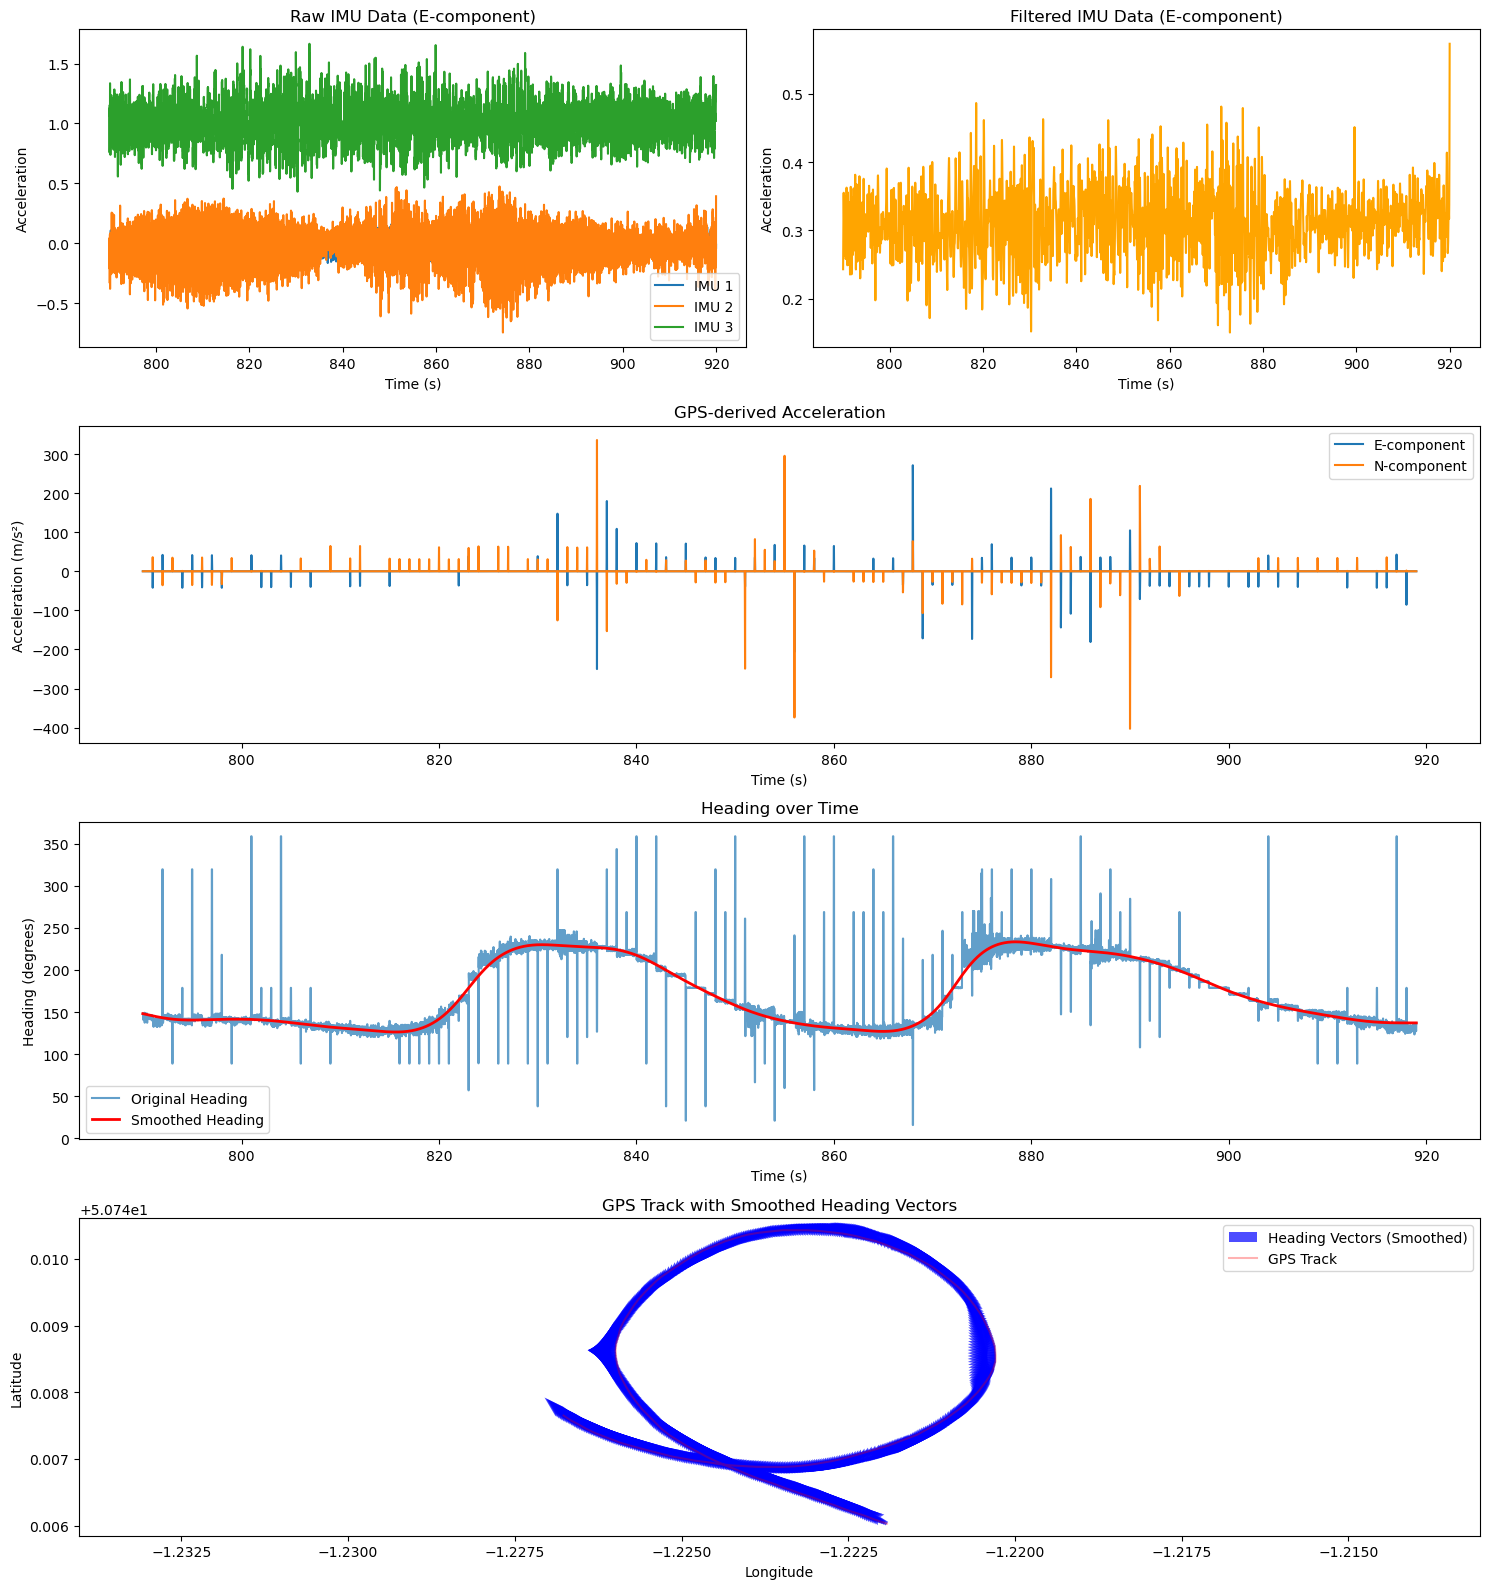

In [16]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# === Transformation Functions === (unchanged)
def transform_accel_imu3(x, y, z):
    E = -z
    N = y 
    U = x
    return E, N, U

def transform_accel_imu4(x, y, z):
    E = y
    N = z
    U = x 
    return E, N, U

def transform_accel_wb(x, y, z):
    E = z
    N = -y
    U = x
    return E, N, U

def resample_data(time, data, target_freq=100):
    """Resample data to target frequency"""
    duration = time[-1] - time[0]
    num_samples = int(duration * target_freq)
    new_time = np.linspace(time[0], time[-1], num_samples)
    
    # Create interpolation function for each column
    if data.ndim == 1:
        interp_func = interp1d(time, data, kind='linear', axis=0)
        resampled_data = interp_func(new_time)
    else:
        resampled_data = np.zeros((num_samples, data.shape[1]))
        for i in range(data.shape[1]):
            interp_func = interp1d(time, data[:, i], kind='linear', axis=0)
            resampled_data[:, i] = interp_func(new_time)
    
    return new_time, resampled_data

def read_imu_data(base_path, test_name):
    """Read and transform IMU data from all sensors"""
    sensors = ['Sensor_3', 'Sensor_4', 'Sensor_wb']
    sensor_data = []
    min_time = float('inf')
    max_time = float('-inf')
    
    # First pass: determine common time range
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        time = accel_df['time_from_sync'].values
        min_time = min(min_time, time[0])
        max_time = max(max_time, time[-1])
    
    # Create common time array
    target_freq = 100
    num_samples = int((max_time - min_time) * target_freq)
    common_time = np.linspace(min_time, max_time, num_samples)
    
    # Second pass: resample all sensors to common time
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        
        # Transform accelerations based on sensor
        x, y, z = accel_df['x'], accel_df['y'], accel_df['z']
        if sensor == 'Sensor_3':
            E, N, U = transform_accel_imu3(x, y, z)
        elif sensor == 'Sensor_4':
            E, N, U = transform_accel_imu4(x, y, z)
        else:  # Sensor_wb
            E, N, U = transform_accel_wb(x, y, z)
            
        current_data = np.column_stack((E, N, U))
        time = accel_df['time_from_sync'].values
        
        # Resample to common time array
        resampled_data = np.zeros((len(common_time), 3))
        for i in range(3):
            interp_func = interp1d(time, current_data[:, i], kind='linear', bounds_error=False, fill_value='extrapolate')
            resampled_data[:, i] = interp_func(common_time)
        
        sensor_data.append(resampled_data)
    
    # Stack all sensor data into a 3D array
    combined_data = np.stack(sensor_data, axis=0)
    return {'time': common_time, 'accel': combined_data}


def preprocess_imu(accel_data):
    # Average across 3 IMUs
    combined_accel = np.mean(accel_data, axis=0)
    # Apply low-pass filter to reduce noise
    b, a = butter(4, 0.1, btype='low')
    filtered_accel = filtfilt(b, a, combined_accel, axis=0)
    return filtered_accel

# === GPS Functions === (unchanged)
def gps_acceleration(lat, lng, time):
    R = 6371000  # Earth radius in meters
    
    # Convert to meters
    x = R * np.cos(np.radians(lat)) * np.cos(np.radians(lng))
    y = R * np.cos(np.radians(lat)) * np.sin(np.radians(lng))
    
    # Calculate velocity and acceleration
    dx = np.gradient(x, time)
    dy = np.gradient(y, time)
    ax = np.gradient(dx, time)
    ay = np.gradient(dy, time)
    
    return np.column_stack((ax, ay))

def read_gps_data(base_path, test_name):
    """Read GPS data"""
    gps_path = os.path.join(base_path, test_name, 'GPS', f'GPS_{test_name}.csv')
    gps_df = pd.read_csv(gps_path)
    return {
        'lat': gps_df['Lat'].values,
        'lng': gps_df['Lng'].values,
        'time_from_sync': gps_df['time_from_sync'].values
    }

def compute_heading(imu_accel, gps_accel):
    heading = np.arctan2(gps_accel[:, 1], gps_accel[:, 0])
    heading_deg = np.degrees(heading) % 360
    return heading_deg

def smooth_heading(heading_deg, fs=100, cutoff=0.1, order=4):
    """
    Smooth the heading angle data using a Butterworth low-pass filter.
    
    Parameters:
    - heading_deg: Original heading in degrees.
    - fs: Sampling frequency in Hz.
    - cutoff: Cutoff frequency for the filter.
    - order: Order of the Butterworth filter.
    
    Returns:
    - smoothed_heading_deg: Smoothed heading in degrees.
    """
    # Convert degrees to radians for filtering
    heading_rad = np.radians(heading_deg)
    
    # To handle the circular nature, filter sine and cosine separately
    sin_heading = np.sin(heading_rad)
    cos_heading = np.cos(heading_rad)
    
    b, a = butter(order, cutoff, btype='low', fs=fs)
    sin_filtered = filtfilt(b, a, sin_heading)
    cos_filtered = filtfilt(b, a, cos_heading)
    
    # Recompute the heading from the filtered sine and cosine
    smoothed_heading_rad = np.arctan2(sin_filtered, cos_filtered)
    smoothed_heading_deg = (np.degrees(smoothed_heading_rad) % 360)
    
    return smoothed_heading_deg

def calculate_heading(base_path, test_name, window_size=5):
    # Read data
    imu_data = read_imu_data(base_path, test_name)
    gps_data = read_gps_data(base_path, test_name)

    # Process pipeline
    imu_accel = preprocess_imu(imu_data['accel'])
    gps_acc = gps_acceleration(gps_data['lat'], gps_data['lng'], gps_data['time_from_sync'])
    heading = compute_heading(imu_accel, gps_acc)
    
    # Smooth the heading
    smoothed_heading = smooth_heading(heading, fs=100, cutoff=0.05, order=4)  # Adjust cutoff as needed

    return heading, smoothed_heading

def plot_data(base_path, test_name):
    # Read data
    imu_data = read_imu_data(base_path, test_name)
    gps_data = read_gps_data(base_path, test_name)
    
    # Resample GPS data to match IMU time
    gps_time, gps_lat = resample_data(gps_data['time_from_sync'], gps_data['lat'])
    _, gps_lng = resample_data(gps_data['time_from_sync'], gps_data['lng'])
    
    # Compute accelerations and headings
    imu_accel = preprocess_imu(imu_data['accel'])
    gps_acc = gps_acceleration(gps_lat, gps_lng, gps_time)
    original_heading, smoothed_heading = compute_heading(imu_accel, gps_acc), smooth_heading(compute_heading(imu_accel, gps_acc))
    
    # Alternatively, using calculate_heading function
    # original_heading, smoothed_heading = calculate_heading(base_path, test_name)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 16))  # Increased height for better layout
    gs = plt.GridSpec(4, 2)  # Adjust grid to accommodate additional plots if needed

    # 1. Raw IMU Data
    ax1 = fig.add_subplot(gs[0, 0])
    for i in range(3):
        ax1.plot(imu_data['time'], imu_data['accel'][i, :, 0], label=f'IMU {i+1}')
    ax1.set_title('Raw IMU Data (E-component)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Acceleration')
    ax1.legend()

    # 2. Filtered IMU Data
    ax2 = fig.add_subplot(gs[0, 1])
    filtered_imu = preprocess_imu(imu_data['accel'])
    ax2.plot(imu_data['time'], filtered_imu[:, 0], color='orange')
    ax2.set_title('Filtered IMU Data (E-component)') 
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Acceleration')

    # 3. GPS Acceleration
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(gps_time, gps_acc[:, 0], label='E-component')
    ax3.plot(gps_time, gps_acc[:, 1], label='N-component')
    ax3.set_title('GPS-derived Acceleration')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.legend()

    # 4. Heading over time (Original and Smoothed)
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(gps_time, original_heading, label='Original Heading', alpha=0.7)
    ax4.plot(gps_time, smoothed_heading, label='Smoothed Heading', color='red', linewidth=2)
    ax4.set_title('Heading over Time')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Heading (degrees)')
    ax4.legend()

    # 5. Quiver plot with Smoothed Heading
    ax5 = fig.add_subplot(gs[3, :])
    
    # Sample every nth point for clearer visualization
    n = 20
    smoothed_heading_rad = np.radians(smoothed_heading[::n])
    u = np.cos(smoothed_heading_rad)
    v = np.sin(smoothed_heading_rad)

    ax5.quiver(gps_lng[::n], gps_lat[::n], u, v,
               scale=50, width=0.003, color='blue', alpha=0.7, label='Heading Vectors (Smoothed)')
    ax5.plot(gps_lng, gps_lat, 'r-', alpha=0.3, label='GPS Track')
    ax5.set_title('GPS Track with Smoothed Heading Vectors')
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Latitude')
    ax5.axis('equal')
    ax5.legend()

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    base_path = '../'
    test_name = '007_Fast_stbd_turn_1'
    plot_data(base_path, test_name)


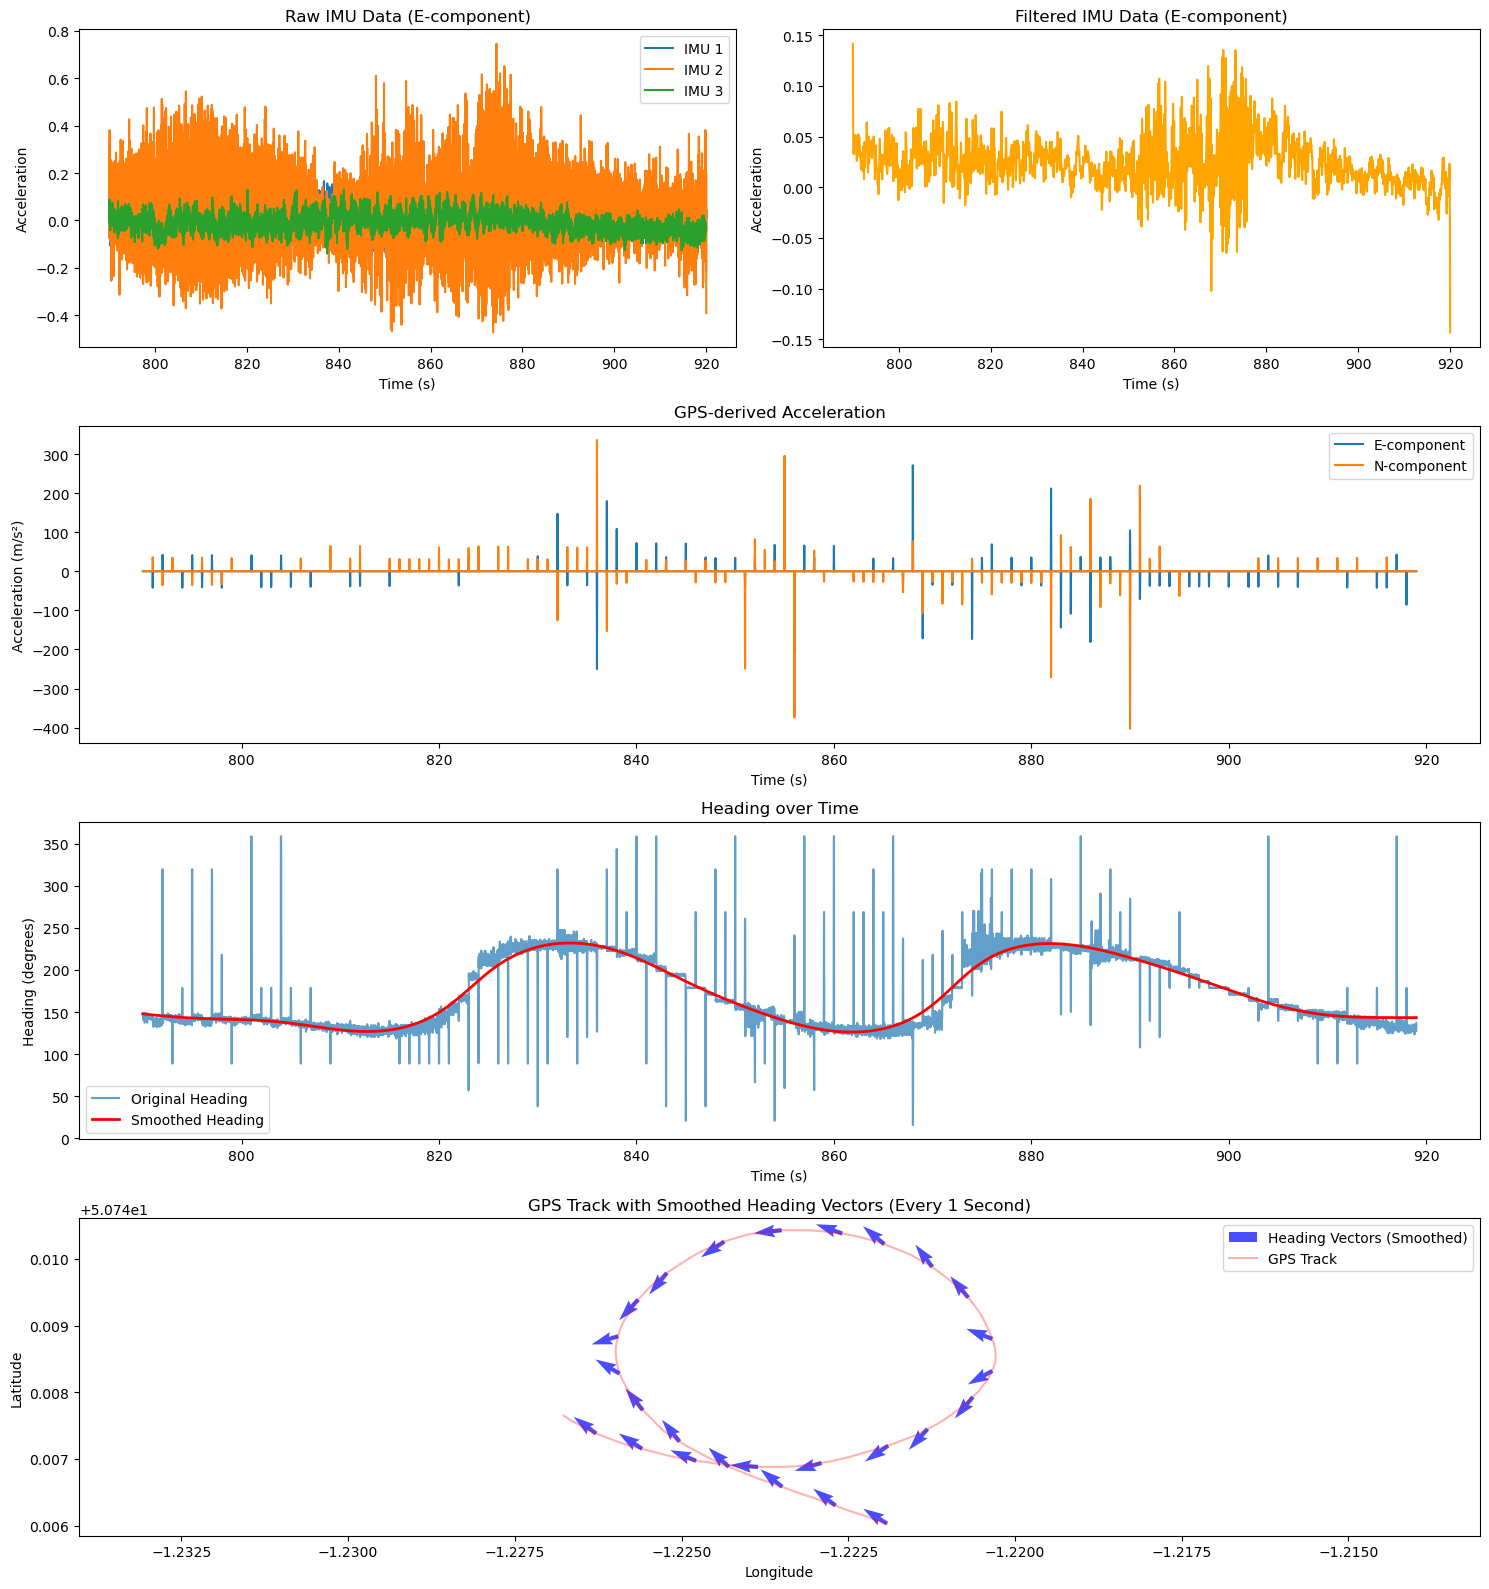

In [19]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# === Transformation Functions === (unchanged)

def transform_accel_imu3(x, y, z):
    E = z
    N = y
    U = x
    return E, N, U

def transform_accel_imu4(x, y, z):
    E = -y
    N = z
    U = x
    return E, N, U

def transform_accel_wb(x, y, z):
    E = y
    N = x
    U = z
    return E, N, U


def resample_data(time, data, target_freq=100):
    """Resample data to target frequency"""
    duration = time[-1] - time[0]
    num_samples = int(duration * target_freq)
    new_time = np.linspace(time[0], time[-1], num_samples)
    
    # Create interpolation function for each column
    if data.ndim == 1:
        interp_func = interp1d(time, data, kind='linear', axis=0)
        resampled_data = interp_func(new_time)
    else:
        resampled_data = np.zeros((num_samples, data.shape[1]))
        for i in range(data.shape[1]):
            interp_func = interp1d(time, data[:, i], kind='linear', axis=0)
            resampled_data[:, i] = interp_func(new_time)
    
    return new_time, resampled_data

def read_imu_data(base_path, test_name):
    """Read and transform IMU data from all sensors"""
    sensors = ['Sensor_3', 'Sensor_4', 'Sensor_wb']
    sensor_data = []
    min_time = float('inf')
    max_time = float('-inf')
    
    # First pass: determine common time range
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        time = accel_df['time_from_sync'].values
        min_time = min(min_time, time[0])
        max_time = max(max_time, time[-1])
    
    # Create common time array
    target_freq = 100
    num_samples = int((max_time - min_time) * target_freq)
    common_time = np.linspace(min_time, max_time, num_samples)
    
    # Second pass: resample all sensors to common time
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        
        # Transform accelerations based on sensor
        x, y, z = accel_df['x'], accel_df['y'], accel_df['z']
        if sensor == 'Sensor_3':
            E, N, U = transform_accel_imu3(x, y, z)
        elif sensor == 'Sensor_4':
            E, N, U = transform_accel_imu4(x, y, z)
        else:  # Sensor_wb
            E, N, U = transform_accel_wb(x, y, z)
            
        current_data = np.column_stack((E, N, U))
        time = accel_df['time_from_sync'].values
        
        # Resample to common time array
        resampled_data = np.zeros((len(common_time), 3))
        for i in range(3):
            interp_func = interp1d(time, current_data[:, i], kind='linear', bounds_error=False, fill_value='extrapolate')
            resampled_data[:, i] = interp_func(common_time)
        
        sensor_data.append(resampled_data)
    
    # Stack all sensor data into a 3D array
    combined_data = np.stack(sensor_data, axis=0)
    return {'time': common_time, 'accel': combined_data}


def preprocess_imu(accel_data):
    # Average across 3 IMUs
    combined_accel = np.mean(accel_data, axis=0)
    # Apply low-pass filter to reduce noise
    b, a = butter(4, 0.1, btype='low')
    filtered_accel = filtfilt(b, a, combined_accel, axis=0)
    return filtered_accel

# === GPS Functions === (unchanged)
def gps_acceleration(lat, lng, time):
    R = 6371000  # Earth radius in meters
    
    # Convert to meters
    x = R * np.cos(np.radians(lat)) * np.cos(np.radians(lng))
    y = R * np.cos(np.radians(lat)) * np.sin(np.radians(lng))
    
    # Calculate velocity and acceleration
    dx = np.gradient(x, time)
    dy = np.gradient(y, time)
    ax = np.gradient(dx, time)
    ay = np.gradient(dy, time)
    
    return np.column_stack((ax, ay))

def read_gps_data(base_path, test_name):
    """Read GPS data"""
    gps_path = os.path.join(base_path, test_name, 'GPS', f'GPS_{test_name}.csv')
    gps_df = pd.read_csv(gps_path)
    return {
        'lat': gps_df['Lat'].values,
        'lng': gps_df['Lng'].values,
        'time_from_sync': gps_df['time_from_sync'].values
    }

def compute_heading(imu_accel, gps_accel):
    heading = np.arctan2(gps_accel[:, 1], gps_accel[:, 0])
    heading_deg = np.degrees(heading) % 360
    return heading_deg

def smooth_heading(heading_deg, fs=100, cutoff=0.05, order=4):
    """
    Smooth the heading angle data using a Butterworth low-pass filter.
    
    Parameters:
    - heading_deg: Original heading in degrees.
    - fs: Sampling frequency in Hz.
    - cutoff: Cutoff frequency for the filter (Hz).
    - order: Order of the Butterworth filter.
    
    Returns:
    - smoothed_heading_deg: Smoothed heading in degrees.
    """
    # Convert degrees to radians for filtering
    heading_rad = np.radians(heading_deg)
    
    # To handle the circular nature, filter sine and cosine separately
    sin_heading = np.sin(heading_rad)
    cos_heading = np.cos(heading_rad)
    
    b, a = butter(order, cutoff, btype='low', fs=fs)
    sin_filtered = filtfilt(b, a, sin_heading)
    cos_filtered = filtfilt(b, a, cos_heading)
    
    # Recompute the heading from the filtered sine and cosine
    smoothed_heading_rad = np.arctan2(sin_filtered, cos_filtered)
    smoothed_heading_deg = (np.degrees(smoothed_heading_rad) % 360)
    
    return smoothed_heading_deg

def calculate_heading(base_path, test_name, window_size=5):
    # Read data
    imu_data = read_imu_data(base_path, test_name)
    gps_data = read_gps_data(base_path, test_name)

    # Process pipeline
    imu_accel = preprocess_imu(imu_data['accel'])
    gps_acc = gps_acceleration(gps_data['lat'], gps_data['lng'], gps_data['time_from_sync'])
    original_heading = compute_heading(imu_accel, gps_acc)
    
    # Smooth the heading
    smoothed_heading = smooth_heading(original_heading, fs=100, cutoff=0.05, order=4)  # Adjust cutoff as needed

    return original_heading, smoothed_heading

def plot_data(base_path, test_name):
    # Read data
    imu_data = read_imu_data(base_path, test_name)
    gps_data = read_gps_data(base_path, test_name)
    
    # Resample GPS data to match IMU time
    gps_time, gps_lat = resample_data(gps_data['time_from_sync'], gps_data['lat'])
    _, gps_lng = resample_data(gps_data['time_from_sync'], gps_data['lng'])
    
    # Compute accelerations and headings
    imu_accel = preprocess_imu(imu_data['accel'])
    gps_acc = gps_acceleration(gps_lat, gps_lng, gps_time)
    original_heading, smoothed_heading = compute_heading(imu_accel, gps_acc), smooth_heading(compute_heading(imu_accel, gps_acc))
    
    # Alternatively, using calculate_heading function
    # original_heading, smoothed_heading = calculate_heading(base_path, test_name)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 16))  # Increased height for better layout
    gs = plt.GridSpec(4, 2)  # Adjust grid to accommodate additional plots if needed

    # 1. Raw IMU Data
    ax1 = fig.add_subplot(gs[0, 0])
    for i in range(3):
        ax1.plot(imu_data['time'], imu_data['accel'][i, :, 0], label=f'IMU {i+1}')
    ax1.set_title('Raw IMU Data (E-component)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Acceleration')
    ax1.legend()

    # 2. Filtered IMU Data
    ax2 = fig.add_subplot(gs[0, 1])
    filtered_imu = preprocess_imu(imu_data['accel'])
    ax2.plot(imu_data['time'], filtered_imu[:, 0], color='orange')
    ax2.set_title('Filtered IMU Data (E-component)') 
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Acceleration')

    # 3. GPS Acceleration
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(gps_time, gps_acc[:, 0], label='E-component')
    ax3.plot(gps_time, gps_acc[:, 1], label='N-component')
    ax3.set_title('GPS-derived Acceleration')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.legend()

    # 4. Heading over time (Original and Smoothed)
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(gps_time, original_heading, label='Original Heading', alpha=0.7)
    ax4.plot(gps_time, smoothed_heading, label='Smoothed Heading', color='red', linewidth=2)
    ax4.set_title('Heading over Time')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Heading (degrees)')
    ax4.legend()

    # 5. Quiver plot with Smoothed Heading
    ax5 = fig.add_subplot(gs[3, :])
    
    # Define desired interval in seconds
    interval_sec = 5  # Place an arrow every 1 second

    # Sampling frequency (Hz)
    fs = 100  # As defined in read_imu_data
    
    # Calculate the number of samples per interval
    n = int(fs * interval_sec)
    
    # Ensure n is at least 1 to avoid zero division
    n = max(n, 1)
    
    # Subsample the data
    subsample_indices = np.arange(0, len(gps_time), n)
    subsample_lng = gps_lng[subsample_indices]
    subsample_lat = gps_lat[subsample_indices]
    subsample_heading = smoothed_heading[subsample_indices]
    
    # Convert heading to radians
    smoothed_heading_rad = np.radians(subsample_heading)
    
    # Calculate u and v components for quiver
    u = np.cos(smoothed_heading_rad)
    v = np.sin(smoothed_heading_rad)

    # Plot quiver
    ax5.quiver(subsample_lng, subsample_lat, u, v,
               scale=50, width=0.003, color='blue', alpha=0.7, label='Heading Vectors (Smoothed)')
    ax5.plot(gps_lng, gps_lat, 'r-', alpha=0.3, label='GPS Track')
    ax5.set_title('GPS Track with Smoothed Heading Vectors (Every 1 Second)')
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Latitude')
    ax5.axis('equal')
    ax5.legend()

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    base_path = '../'
    test_name = '007_Fast_stbd_turn_1'
    plot_data(base_path, test_name)


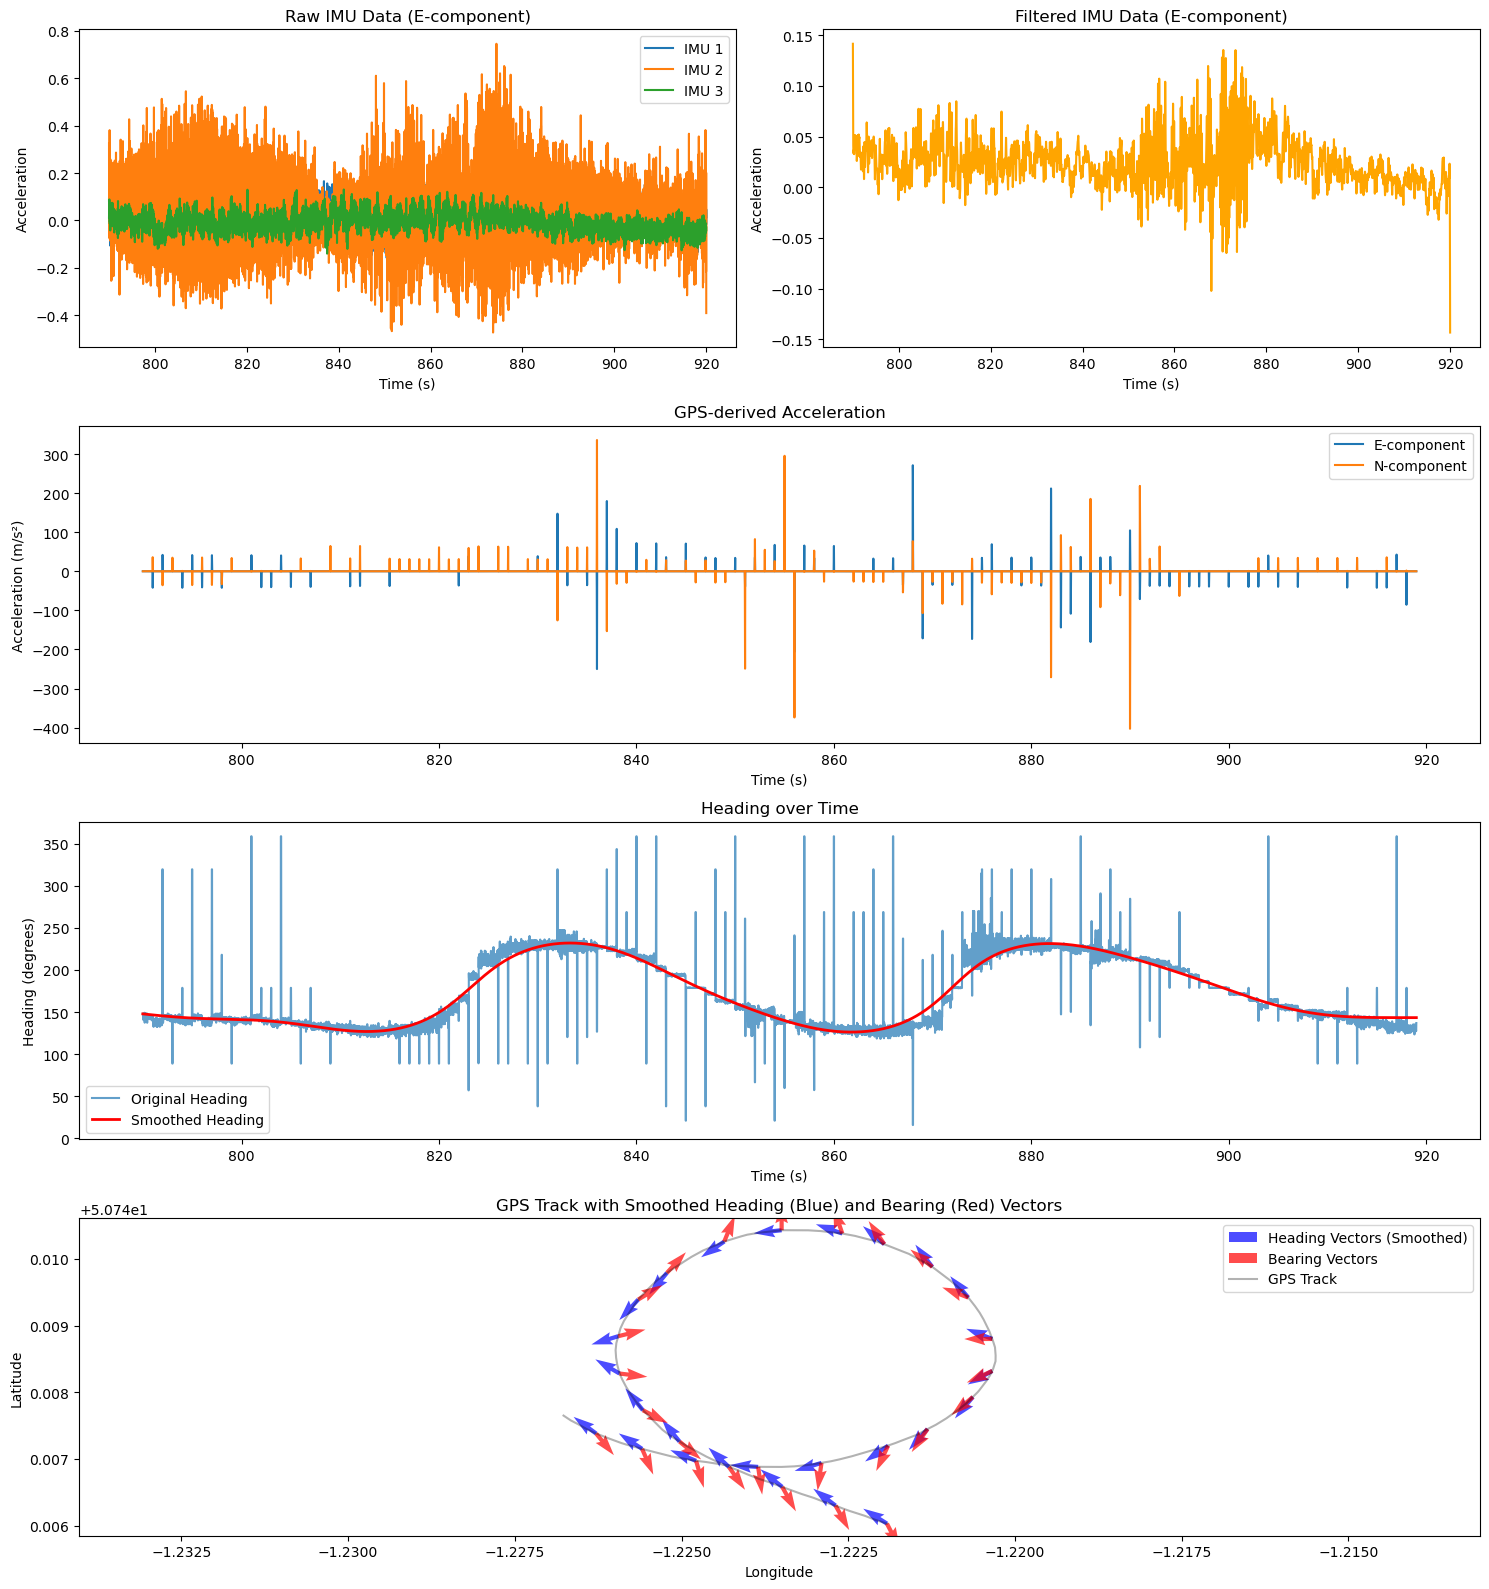

In [26]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# === Transformation Functions === (unchanged)

def transform_accel_imu3(x, y, z):
    E = z
    N = y
    U = x
    return E, N, U

def transform_accel_imu4(x, y, z):
    E = -y
    N = z
    U = x
    return E, N, U

def transform_accel_wb(x, y, z):
    E = y
    N = x
    U = z
    return E, N, U

def resample_data(time, data, target_freq=100):
    """Resample data to target frequency"""
    duration = time[-1] - time[0]
    num_samples = int(duration * target_freq)
    new_time = np.linspace(time[0], time[-1], num_samples)
    
    # Create interpolation function for each column
    if data.ndim == 1:
        interp_func = interp1d(time, data, kind='linear', axis=0)
        resampled_data = interp_func(new_time)
    else:
        resampled_data = np.zeros((num_samples, data.shape[1]))
        for i in range(data.shape[1]):
            interp_func = interp1d(time, data[:, i], kind='linear', axis=0)
            resampled_data[:, i] = interp_func(new_time)
    
    return new_time, resampled_data

def read_imu_data(base_path, test_name):
    """Read and transform IMU data from all sensors"""
    sensors = ['Sensor_3', 'Sensor_4', 'Sensor_wb']
    sensor_data = []
    min_time = float('inf')
    max_time = float('-inf')
    
    # First pass: determine common time range
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        time = accel_df['time_from_sync'].values
        min_time = min(min_time, time[0])
        max_time = max(max_time, time[-1])
    
    # Create common time array
    target_freq = 100
    num_samples = int((max_time - min_time) * target_freq)
    common_time = np.linspace(min_time, max_time, num_samples)
    
    # Second pass: resample all sensors to common time
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        
        # Transform accelerations based on sensor
        x, y, z = accel_df['x'], accel_df['y'], accel_df['z']
        if sensor == 'Sensor_3':
            E, N, U = transform_accel_imu3(x, y, z)
        elif sensor == 'Sensor_4':
            E, N, U = transform_accel_imu4(x, y, z)
        else:  # Sensor_wb
            E, N, U = transform_accel_wb(x, y, z)
            
        current_data = np.column_stack((E, N, U))
        time = accel_df['time_from_sync'].values
        
        # Resample to common time array
        resampled_data = np.zeros((len(common_time), 3))
        for i in range(3):
            interp_func = interp1d(time, current_data[:, i], kind='linear', bounds_error=False, fill_value='extrapolate')
            resampled_data[:, i] = interp_func(common_time)
        
        sensor_data.append(resampled_data)
    
    # Stack all sensor data into a 3D array
    combined_data = np.stack(sensor_data, axis=0)
    return {'time': common_time, 'accel': combined_data}

def preprocess_imu(accel_data):
    # Average across 3 IMUs
    combined_accel = np.mean(accel_data, axis=0)
    # Apply low-pass filter to reduce noise
    b, a = butter(4, 0.1, btype='low')
    filtered_accel = filtfilt(b, a, combined_accel, axis=0)
    return filtered_accel

# === GPS Functions === (modified to include 'Bearing')
def gps_acceleration(lat, lng, time):
    R = 6371000  # Earth radius in meters
    
    # Convert to meters
    x = R * np.cos(np.radians(lat)) * np.cos(np.radians(lng))
    y = R * np.cos(np.radians(lat)) * np.sin(np.radians(lng))
    
    # Calculate velocity and acceleration
    dx = np.gradient(x, time)
    dy = np.gradient(y, time)
    ax = np.gradient(dx, time)
    ay = np.gradient(dy, time)
    
    return np.column_stack((ax, ay))

def read_gps_data(base_path, test_name):
    """Read GPS data, including Bearing"""
    gps_path = os.path.join(base_path, test_name, 'GPS', f'GPS_{test_name}.csv')
    gps_df = pd.read_csv(gps_path)
    return {
        'lat': gps_df['Lat'].values,
        'lng': gps_df['Lng'].values,
        'bearing': gps_df['Bearing'].values,  # Added 'Bearing'
        'time_from_sync': gps_df['time_from_sync'].values
    }

def compute_heading(imu_accel, gps_accel):
    heading = np.arctan2(gps_accel[:, 1], gps_accel[:, 0])
    heading_deg = np.degrees(heading) % 360
    return heading_deg

def smooth_heading(heading_deg, fs=100, cutoff=0.05, order=4):
    """
    Smooth the heading angle data using a Butterworth low-pass filter.
    
    Parameters:
    - heading_deg: Original heading in degrees.
    - fs: Sampling frequency in Hz.
    - cutoff: Cutoff frequency for the filter (Hz).
    - order: Order of the Butterworth filter.
    
    Returns:
    - smoothed_heading_deg: Smoothed heading in degrees.
    """
    # Convert degrees to radians for filtering
    heading_rad = np.radians(heading_deg)
    
    # To handle the circular nature, filter sine and cosine separately
    sin_heading = np.sin(heading_rad)
    cos_heading = np.cos(heading_rad)
    
    b, a = butter(order, cutoff, btype='low', fs=fs)
    sin_filtered = filtfilt(b, a, sin_heading)
    cos_filtered = filtfilt(b, a, cos_heading)
    
    # Recompute the heading from the filtered sine and cosine
    smoothed_heading_rad = np.arctan2(sin_filtered, cos_filtered)
    smoothed_heading_deg = (np.degrees(smoothed_heading_rad) % 360)
    
    return smoothed_heading_deg

def calculate_heading(base_path, test_name, window_size=5):
    # Read data
    imu_data = read_imu_data(base_path, test_name)
    gps_data = read_gps_data(base_path, test_name)

    # Process pipeline
    imu_accel = preprocess_imu(imu_data['accel'])
    gps_acc = gps_acceleration(gps_data['lat'], gps_data['lng'], gps_data['time_from_sync'])
    original_heading = compute_heading(imu_accel, gps_acc)
    
    # Smooth the heading
    smoothed_heading = smooth_heading(original_heading, fs=100, cutoff=0.05, order=4)  # Adjust cutoff as needed

    return original_heading, smoothed_heading

def plot_data(base_path, test_name):
    # Read data
    imu_data = read_imu_data(base_path, test_name)
    gps_data = read_gps_data(base_path, test_name)
    
    # Resample GPS data to match IMU time
    gps_time, gps_lat = resample_data(gps_data['time_from_sync'], gps_data['lat'])
    _, gps_lng = resample_data(gps_data['time_from_sync'], gps_data['lng'])
    _, gps_bearing = resample_data(gps_data['time_from_sync'], gps_data['bearing'])  # Resample 'Bearing'
    
    # Compute accelerations and headings
    imu_accel = preprocess_imu(imu_data['accel'])
    gps_acc = gps_acceleration(gps_lat, gps_lng, gps_time)
    original_heading = compute_heading(imu_accel, gps_acc)
    
    # Smooth the heading
    smoothed_heading = smooth_heading(original_heading, fs=100, cutoff=0.05, order=4)  # Adjust cutoff as needed
    
    # Alternatively, using calculate_heading function
    # original_heading, smoothed_heading = calculate_heading(base_path, test_name)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 16))  # Increased height for better layout
    gs = plt.GridSpec(4, 2)  # Adjust grid to accommodate additional plots if needed

    # 1. Raw IMU Data
    ax1 = fig.add_subplot(gs[0, 0])
    for i in range(3):
        ax1.plot(imu_data['time'], imu_data['accel'][i, :, 0], label=f'IMU {i+1}')
    ax1.set_title('Raw IMU Data (E-component)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Acceleration')
    ax1.legend()

    # 2. Filtered IMU Data
    ax2 = fig.add_subplot(gs[0, 1])
    filtered_imu = preprocess_imu(imu_data['accel'])
    ax2.plot(imu_data['time'], filtered_imu[:, 0], color='orange')
    ax2.set_title('Filtered IMU Data (E-component)') 
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Acceleration')

    # 3. GPS Acceleration
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(gps_time, gps_acc[:, 0], label='E-component')
    ax3.plot(gps_time, gps_acc[:, 1], label='N-component')
    ax3.set_title('GPS-derived Acceleration')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.legend()

    # 4. Heading over time (Original and Smoothed)
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(gps_time, original_heading, label='Original Heading', alpha=0.7)
    ax4.plot(gps_time, smoothed_heading, label='Smoothed Heading', color='red', linewidth=2)
    ax4.set_title('Heading over Time')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Heading (degrees)')
    ax4.legend()

    # 5. Quiver plot with Smoothed Heading and Bearing
    ax5 = fig.add_subplot(gs[3, :])
    
    # Define desired interval in seconds
    interval_sec = 5  # Place an arrow every 5 seconds
    
    # Sampling frequency (Hz)
    fs = 100  # As defined in read_imu_data
    
    # Calculate the number of samples per interval
    n = int(fs * interval_sec)
    
    # Ensure n is at least 1 to avoid zero division
    n = max(n, 1)
    
    # Subsample the data
    subsample_indices = np.arange(0, len(gps_time), n)
    subsample_lng = gps_lng[subsample_indices]
    subsample_lat = gps_lat[subsample_indices]
    subsample_smoothed_heading = smoothed_heading[subsample_indices]
    subsample_bearing = gps_bearing[subsample_indices]  # Subsample 'Bearing'
    
    # Convert smoothed heading to radians
    smoothed_heading_rad = np.radians(subsample_smoothed_heading)
    
    # Calculate u and v components for smoothed heading
    u_heading = np.cos(smoothed_heading_rad)
    v_heading = np.sin(smoothed_heading_rad)

    # Convert bearing to radians
    bearing_rad = np.radians(subsample_bearing)
    
    # Calculate u and v components for bearing
    u_bearing = np.cos(bearing_rad)
    v_bearing = np.sin(bearing_rad)

    # Plot quiver for smoothed heading (blue arrows)
    q1 = ax5.quiver(subsample_lng, subsample_lat, u_heading, v_heading,
               scale=50, width=0.003, color='blue', alpha=0.7, label='Heading Vectors (Smoothed)')
    
    # Plot quiver for bearing (red arrows)
    q2 = ax5.quiver(subsample_lng, subsample_lat, u_bearing, v_bearing,
               scale=50, width=0.003, color='red', alpha=0.7, label='Bearing Vectors')
    
    # Plot GPS track
    ax5.plot(gps_lng, gps_lat, 'k-', alpha=0.3, label='GPS Track')
    
    ax5.set_title('GPS Track with Smoothed Heading (Blue) and Bearing (Red) Vectors')
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Latitude')
    ax5.axis('equal')
    ax5.legend()

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    base_path = '../'
    test_name = '007_Fast_stbd_turn_1'
    plot_data(base_path, test_name)


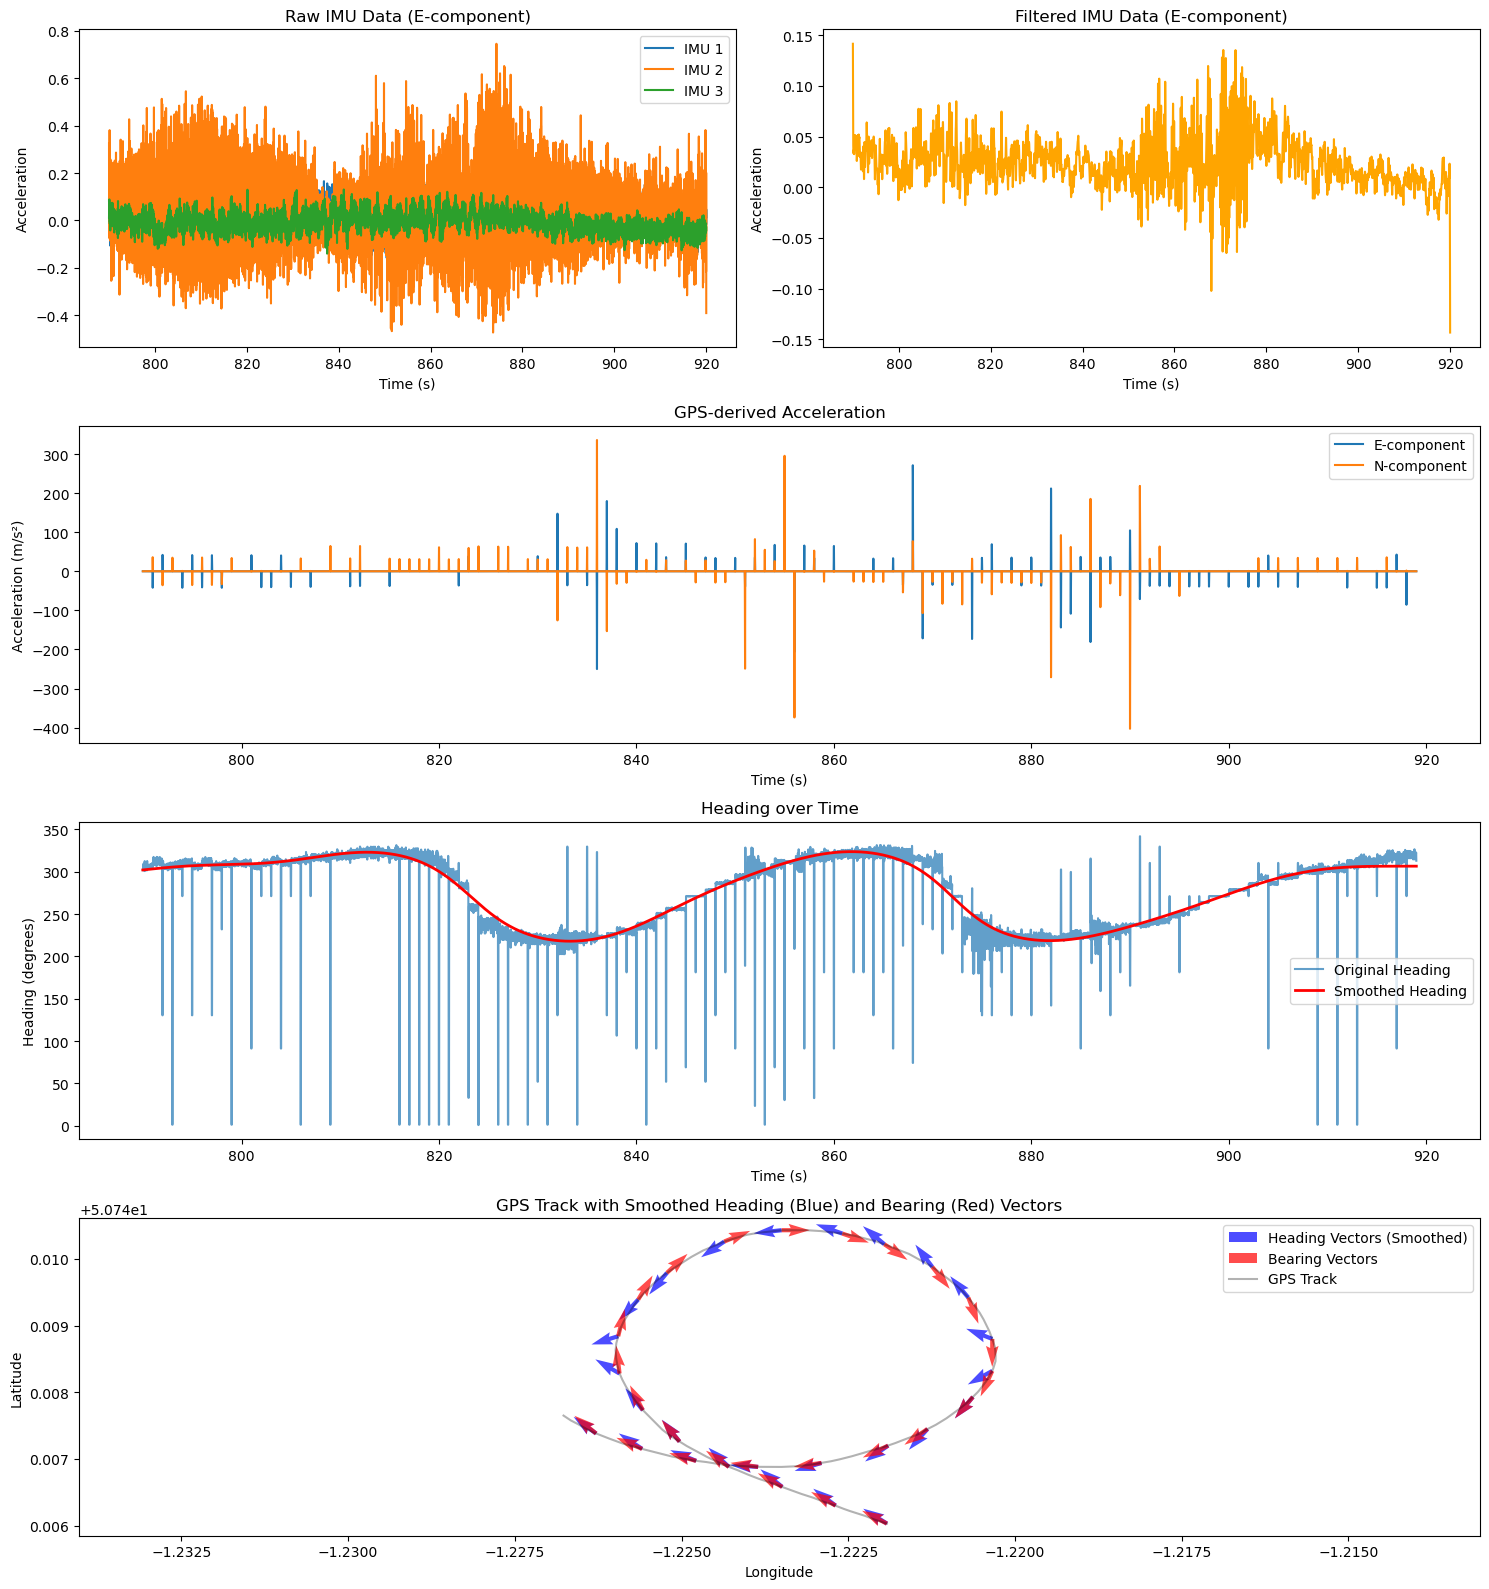

In [27]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# === Transformation Functions === (unchanged)

def transform_accel_imu3(x, y, z):
    E = z
    N = y
    U = x
    return E, N, U

def transform_accel_imu4(x, y, z):
    E = -y
    N = z
    U = x
    return E, N, U

def transform_accel_wb(x, y, z):
    E = y
    N = x
    U = z
    return E, N, U

def resample_data(time, data, target_freq=100):
    """Resample data to target frequency"""
    duration = time[-1] - time[0]
    num_samples = int(duration * target_freq)
    new_time = np.linspace(time[0], time[-1], num_samples)
    
    # Create interpolation function for each column
    if data.ndim == 1:
        interp_func = interp1d(time, data, kind='linear', axis=0)
        resampled_data = interp_func(new_time)
    else:
        resampled_data = np.zeros((num_samples, data.shape[1]))
        for i in range(data.shape[1]):
            interp_func = interp1d(time, data[:, i], kind='linear', axis=0)
            resampled_data[:, i] = interp_func(new_time)
    
    return new_time, resampled_data

def read_imu_data(base_path, test_name):
    """Read and transform IMU data from all sensors"""
    sensors = ['Sensor_3', 'Sensor_4', 'Sensor_wb']
    sensor_data = []
    min_time = float('inf')
    max_time = float('-inf')
    
    # First pass: determine common time range
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        time = accel_df['time_from_sync'].values
        min_time = min(min_time, time[0])
        max_time = max(max_time, time[-1])
    
    # Create common time array
    target_freq = 100
    num_samples = int((max_time - min_time) * target_freq)
    common_time = np.linspace(min_time, max_time, num_samples)
    
    # Second pass: resample all sensors to common time
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        
        # Transform accelerations based on sensor
        x, y, z = accel_df['x'], accel_df['y'], accel_df['z']
        if sensor == 'Sensor_3':
            E, N, U = transform_accel_imu3(x, y, z)
        elif sensor == 'Sensor_4':
            E, N, U = transform_accel_imu4(x, y, z)
        else:  # Sensor_wb
            E, N, U = transform_accel_wb(x, y, z)
            
        current_data = np.column_stack((E, N, U))
        time = accel_df['time_from_sync'].values
        
        # Resample to common time array
        resampled_data = np.zeros((len(common_time), 3))
        for i in range(3):
            interp_func = interp1d(time, current_data[:, i], kind='linear', bounds_error=False, fill_value='extrapolate')
            resampled_data[:, i] = interp_func(common_time)
        
        sensor_data.append(resampled_data)
    
    # Stack all sensor data into a 3D array
    combined_data = np.stack(sensor_data, axis=0)
    return {'time': common_time, 'accel': combined_data}

def preprocess_imu(accel_data):
    # Average across 3 IMUs
    combined_accel = np.mean(accel_data, axis=0)
    # Apply low-pass filter to reduce noise
    b, a = butter(4, 0.1, btype='low')
    filtered_accel = filtfilt(b, a, combined_accel, axis=0)
    return filtered_accel

# === GPS Functions === (modified to include 'Bearing')
def gps_acceleration(lat, lng, time):
    R = 6371000  # Earth radius in meters
    
    # Convert to meters
    x = R * np.cos(np.radians(lat)) * np.cos(np.radians(lng))
    y = R * np.cos(np.radians(lat)) * np.sin(np.radians(lng))
    
    # Calculate velocity and acceleration
    dx = np.gradient(x, time)
    dy = np.gradient(y, time)
    ax = np.gradient(dx, time)
    ay = np.gradient(dy, time)
    
    return np.column_stack((ax, ay))

def read_gps_data(base_path, test_name):
    """Read GPS data, including Bearing"""
    gps_path = os.path.join(base_path, test_name, 'GPS', f'GPS_{test_name}.csv')
    gps_df = pd.read_csv(gps_path)
    return {
        'lat': gps_df['Lat'].values,
        'lng': gps_df['Lng'].values,
        'bearing': gps_df['Bearing'].values,  # Added 'Bearing'
        'time_from_sync': gps_df['time_from_sync'].values
    }

def compute_heading(imu_accel, gps_accel):
    heading = np.arctan2(gps_accel[:, 1], gps_accel[:, 0])
    heading_deg = (90 - np.degrees(heading)) % 360  # Convert to bearing degrees
    return heading_deg

def smooth_heading(heading_deg, fs=100, cutoff=0.05, order=4):
    """
    Smooth the heading angle data using a Butterworth low-pass filter.
    
    Parameters:
    - heading_deg: Original heading in degrees.
    - fs: Sampling frequency in Hz.
    - cutoff: Cutoff frequency for the filter (Hz).
    - order: Order of the Butterworth filter.
    
    Returns:
    - smoothed_heading_deg: Smoothed heading in degrees.
    """
    # Convert degrees to radians for filtering
    heading_rad = np.radians(heading_deg)
    
    # To handle the circular nature, filter sine and cosine separately
    sin_heading = np.sin(heading_rad)
    cos_heading = np.cos(heading_rad)
    
    b, a = butter(order, cutoff, btype='low', fs=fs)
    sin_filtered = filtfilt(b, a, sin_heading)
    cos_filtered = filtfilt(b, a, cos_heading)
    
    # Recompute the heading from the filtered sine and cosine
    smoothed_heading_rad = np.arctan2(sin_filtered, cos_filtered)
    smoothed_heading_deg = (np.degrees(smoothed_heading_rad) % 360)
    
    return smoothed_heading_deg

def calculate_heading(base_path, test_name, window_size=5):
    # Read data
    imu_data = read_imu_data(base_path, test_name)
    gps_data = read_gps_data(base_path, test_name)

    # Process pipeline
    imu_accel = preprocess_imu(imu_data['accel'])
    gps_acc = gps_acceleration(gps_data['lat'], gps_data['lng'], gps_data['time_from_sync'])
    original_heading = compute_heading(imu_accel, gps_acc)
    
    # Smooth the heading
    smoothed_heading = smooth_heading(original_heading, fs=100, cutoff=0.05, order=4)  # Adjust cutoff as needed

    return original_heading, smoothed_heading

def plot_data(base_path, test_name):
    # Read data
    imu_data = read_imu_data(base_path, test_name)
    gps_data = read_gps_data(base_path, test_name)
    
    # Resample GPS data to match IMU time
    gps_time, gps_lat = resample_data(gps_data['time_from_sync'], gps_data['lat'])
    _, gps_lng = resample_data(gps_data['time_from_sync'], gps_data['lng'])
    _, gps_bearing = resample_data(gps_data['time_from_sync'], gps_data['bearing'])  # Resample 'Bearing'
    
    # Compute accelerations and headings
    imu_accel = preprocess_imu(imu_data['accel'])
    gps_acc = gps_acceleration(gps_lat, gps_lng, gps_time)
    original_heading = compute_heading(imu_accel, gps_acc)
    
    # Smooth the heading
    smoothed_heading = smooth_heading(original_heading, fs=100, cutoff=0.05, order=4)  # Adjust cutoff as needed
    
    # Alternatively, using calculate_heading function
    # original_heading, smoothed_heading = calculate_heading(base_path, test_name)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 16))  # Increased height for better layout
    gs = plt.GridSpec(4, 2)  # Adjust grid to accommodate additional plots if needed

    # 1. Raw IMU Data
    ax1 = fig.add_subplot(gs[0, 0])
    for i in range(3):
        ax1.plot(imu_data['time'], imu_data['accel'][i, :, 0], label=f'IMU {i+1}')
    ax1.set_title('Raw IMU Data (E-component)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Acceleration')
    ax1.legend()

    # 2. Filtered IMU Data
    ax2 = fig.add_subplot(gs[0, 1])
    filtered_imu = preprocess_imu(imu_data['accel'])
    ax2.plot(imu_data['time'], filtered_imu[:, 0], color='orange')
    ax2.set_title('Filtered IMU Data (E-component)') 
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Acceleration')

    # 3. GPS Acceleration
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(gps_time, gps_acc[:, 0], label='E-component')
    ax3.plot(gps_time, gps_acc[:, 1], label='N-component')
    ax3.set_title('GPS-derived Acceleration')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.legend()

    # 4. Heading over time (Original and Smoothed)
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(gps_time, original_heading, label='Original Heading', alpha=0.7)
    ax4.plot(gps_time, smoothed_heading, label='Smoothed Heading', color='red', linewidth=2)
    ax4.set_title('Heading over Time')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Heading (degrees)')
    ax4.legend()

    # 5. Quiver plot with Smoothed Heading and Bearing
    ax5 = fig.add_subplot(gs[3, :])
    
    # Define desired interval in seconds
    interval_sec = 5  # Place an arrow every 5 seconds
    
    # Sampling frequency (Hz)
    fs = 100  # As defined in read_imu_data
    
    # Calculate the number of samples per interval
    n = int(fs * interval_sec)
    
    # Ensure n is at least 1 to avoid zero division
    n = max(n, 1)
    
    # Subsample the data
    subsample_indices = np.arange(0, len(gps_time), n)
    subsample_lng = gps_lng[subsample_indices]
    subsample_lat = gps_lat[subsample_indices]
    subsample_smoothed_heading = smoothed_heading[subsample_indices]
    subsample_bearing = gps_bearing[subsample_indices]  # Subsample 'Bearing'
    
    # Convert smoothed heading to radians
    smoothed_heading_rad = np.radians(subsample_smoothed_heading)
    
    # Calculate u and v components for smoothed heading (Bearing Convention)
    u_heading = np.sin(smoothed_heading_rad)  # East component
    v_heading = np.cos(smoothed_heading_rad)  # North component

    # Convert bearing to radians
    bearing_rad = np.radians(subsample_bearing)
    
    # Calculate u and v components for bearing (Bearing Convention)
    u_bearing = np.sin(bearing_rad)  # East component
    v_bearing = np.cos(bearing_rad)  # North component

    # Plot quiver for smoothed heading (blue arrows)
    q1 = ax5.quiver(subsample_lng, subsample_lat, u_heading, v_heading,
                scale=50, width=0.003, color='blue', alpha=0.7, label='Heading Vectors (Smoothed)')
    
    # Plot quiver for bearing (red arrows)
    q2 = ax5.quiver(subsample_lng, subsample_lat, u_bearing, v_bearing,
                scale=50, width=0.003, color='red', alpha=0.7, label='Bearing Vectors')
    
    # Plot GPS track
    ax5.plot(gps_lng, gps_lat, 'k-', alpha=0.3, label='GPS Track')
    
    ax5.set_title('GPS Track with Smoothed Heading (Blue) and Bearing (Red) Vectors')
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Latitude')
    ax5.axis('equal')
    ax5.legend()

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    base_path = '../'
    test_name = '007_Fast_stbd_turn_1'
    plot_data(base_path, test_name)


Sensor Sensor_3 resampled shape: (13000, 3)
Sensor Sensor_4 resampled shape: (13000, 3)
Sensor Sensor_wb resampled shape: (13000, 3)


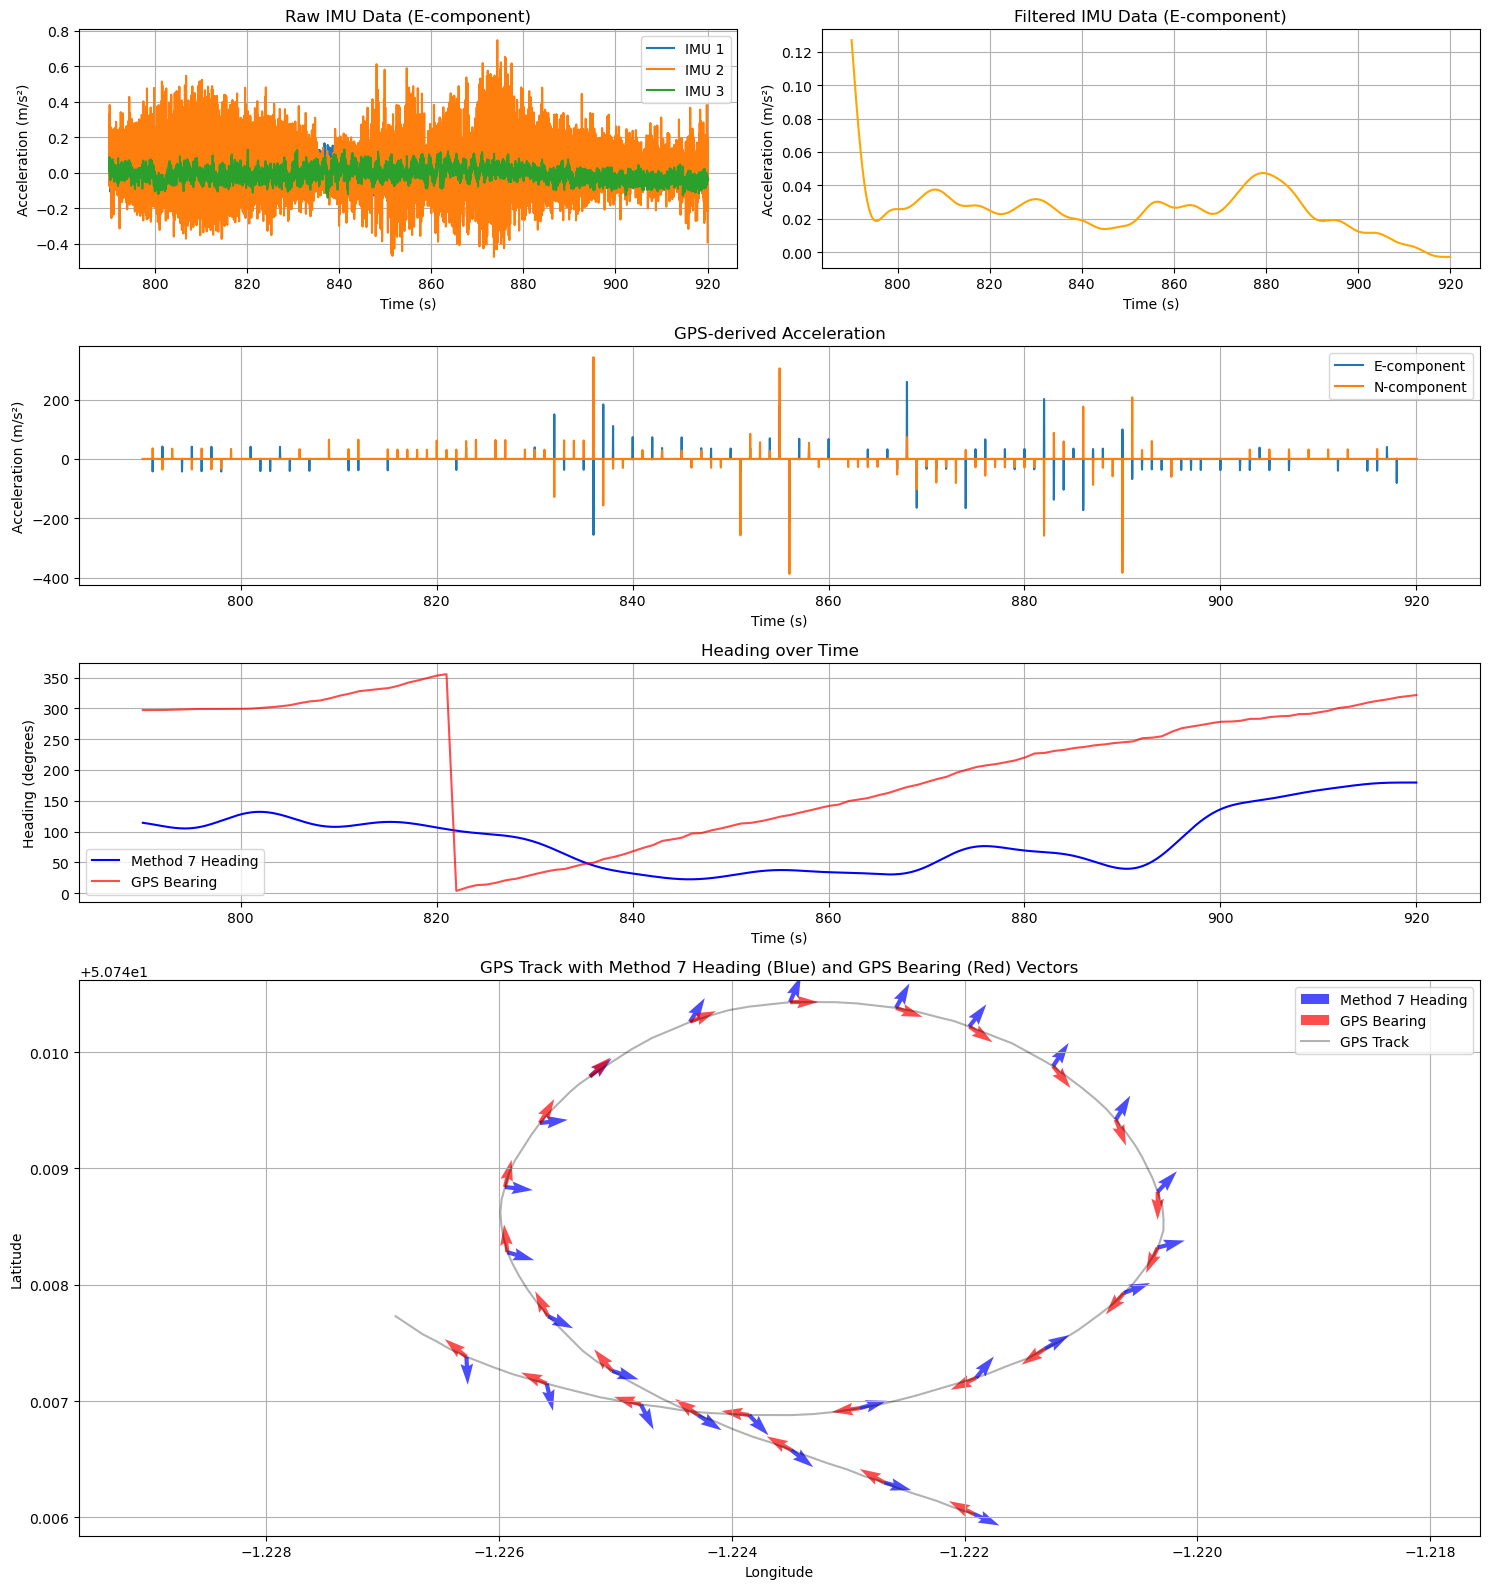

In [6]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
import pandas as pd
import os
import matplotlib.pyplot as plt
from ahrs.filters import Madgwick
from scipy.spatial.transform import Rotation as R

# === Quaternion Multiplication Function ===

def quaternion_multiply(q1, q2):
    """
    Multiply two quaternions.

    Parameters:
    - q1: First quaternion as a numpy array [w, x, y, z]
    - q2: Second quaternion as a numpy array [w, x, y, z]

    Returns:
    - Product quaternion as a numpy array [w, x, y, z]
    """
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

# === VehicleHeadingCalculator Class ===

class VehicleHeadingCalculator:
    def __init__(self, sample_rate=100):
        self.g = 9.81  # Gravity constant (m/s²)
        self.omega_earth = 7.2921e-5  # Earth's rotation rate (rad/s)
        self.sample_rate = sample_rate  # Sampling rate (Hz)
    
    def remove_gravity_coriolis(self, accel, lat, vel_e, vel_n):
        """Remove gravity and Coriolis effects from acceleration measurements."""
        # Calculate Coriolis acceleration
        omega_u = self.omega_earth * np.sin(np.radians(lat))
        
        a_cor_e = 2 * vel_n * omega_u
        a_cor_n = -2 * vel_e * omega_u
        
        # Remove gravity and Coriolis
        accel_corrected = accel.copy()
        accel_corrected[:, 0] -= a_cor_e  # East
        accel_corrected[:, 1] -= a_cor_n  # North
        accel_corrected[:, 2] += self.g    # Up (remove gravity)
        
        return accel_corrected
    
    def transform_body_to_ned(self, accel_body, quaternions):
        """Transform acceleration from body to NED frame using quaternions."""
        accel_ned = np.zeros_like(accel_body)
        for i in range(len(accel_body)):
            q = quaternions[i]
            # Convert quaternion to scipy Rotation object
            rotation = R.from_quat([q[1], q[2], q[3], q[0]])  # scipy expects [x, y, z, w]
            # Rotate acceleration vector
            accel_ned[i] = rotation.apply(accel_body[i])
        return accel_ned
    
    def calculate_gnss_acceleration(self, lat, lon, time):
        """Calculate Earth-fixed acceleration from GNSS measurements."""
        R_earth = 6371000  # Earth radius in meters
        
        # Convert to ECEF coordinates
        x = R_earth * np.cos(np.radians(lat)) * np.cos(np.radians(lon))
        y = R_earth * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
        
        # Calculate velocities
        vel_e = np.gradient(x, time)
        vel_n = np.gradient(y, time)
        
        # Calculate accelerations
        acc_e = np.gradient(vel_e, time)
        acc_n = np.gradient(vel_n, time)
        
        return np.column_stack((acc_e, acc_n)), np.column_stack((vel_e, vel_n))
    
    def compute_heading_method7(self, imu_data, gps_data):
        """Implement Method 7 for heading calculation."""
        # Process IMU data with Madgwick filter
        madgwick = Madgwick(sampleperiod=1/self.sample_rate)
        quaternions = np.zeros((len(imu_data['accel']), 4))
        quaternions[0] = np.array([1, 0, 0, 0])  # Initial quaternion
        
        for i in range(1, len(imu_data['accel'])):
            quaternions[i] = madgwick.updateIMU(
                quaternions[i-1],
                gyr=imu_data['gyro'][i],
                acc=imu_data['accel'][i]
            )
        
        # Transform accelerations to NED frame
        accel_ned = self.transform_body_to_ned(imu_data['accel'], quaternions)
        
        # Calculate GNSS-derived acceleration and velocity
        gnss_acc, gnss_vel = self.calculate_gnss_acceleration(
            gps_data['lat'], 
            gps_data['lng'], 
            gps_data['time']
        )
        
        # Remove gravity and Coriolis effects
        accel_corrected = self.remove_gravity_coriolis(
            accel_ned,
            gps_data['lat'],
            gnss_vel[:, 0],
            gnss_vel[:, 1]
        )
        
        # Calculate heading using horizontal acceleration components
        heading = np.arctan2(accel_corrected[:, 0], accel_corrected[:, 1])
        heading_degrees = np.degrees(heading) % 360
        
        # Apply low-pass filter to smooth the heading
        b, a = butter(4, 0.1, btype='low', fs=self.sample_rate)
        heading_filtered = filtfilt(b, a, heading_degrees)
        
        return heading_filtered

# === Transformation Functions ===

def transform_accel_imu3(x, y, z):
    E = z
    N = y
    U = x
    return E, N, U

def transform_accel_imu4(x, y, z):
    E = -y
    N = z
    U = x
    return E, N, U

def transform_accel_wb(x, y, z):
    E = y
    N = x
    U = z
    return E, N, U

def resample_data(original_time, target_time, data):
    """Resample data from original_time to target_time."""
    if data.ndim == 1:
        interp_func = interp1d(original_time, data, kind='linear', axis=0, fill_value='extrapolate')
        resampled_data = interp_func(target_time)
    else:
        resampled_data = np.zeros((len(target_time), data.shape[1]))
        for i in range(data.shape[1]):
            interp_func = interp1d(original_time, data[:, i], kind='linear', axis=0, fill_value='extrapolate')
            resampled_data[:, i] = interp_func(target_time)
    return resampled_data

def read_imu_data(base_path, test_name):
    """Read and transform IMU data from all sensors."""
    sensors = ['Sensor_3', 'Sensor_4', 'Sensor_wb']
    sensor_data = []
    min_time = float('inf')
    max_time = float('-inf')
    
    # First pass: determine common time range
    sensor_time_ranges = {}
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        time = accel_df['time_from_sync'].values
        sensor_time_ranges[sensor] = (time[0], time[-1])
        min_time = min(min_time, time[0])
        max_time = max(max_time, time[-1])
    
    # Create common time array
    target_freq = 100
    duration = max_time - min_time
    num_samples = int(duration * target_freq)
    common_time = np.linspace(min_time, max_time, num_samples)
    
    # Second pass: resample all sensors to common_time
    for sensor in sensors:
        accel_path = os.path.join(base_path, test_name, 'IMU', sensor, f'accel_{test_name}.csv')
        accel_df = pd.read_csv(accel_path)
        
        # Transform accelerations based on sensor
        x, y, z = accel_df['x'].values, accel_df['y'].values, accel_df['z'].values
        if sensor == 'Sensor_3':
            E, N, U = transform_accel_imu3(x, y, z)
        elif sensor == 'Sensor_4':
            E, N, U = transform_accel_imu4(x, y, z)
        else:  # Sensor_wb
            E, N, U = transform_accel_wb(x, y, z)
            
        current_data = np.column_stack((E, N, U))
        original_time = accel_df['time_from_sync'].values
        
        # Resample to common_time
        resampled_data = resample_data(original_time, common_time, current_data)
        
        sensor_data.append(resampled_data)
    
    # Optional: Verify that all resampled_data have the same shape
    for idx, data in enumerate(sensor_data):
        print(f"Sensor {sensors[idx]} resampled shape: {data.shape}")
    
    # Stack all sensor data into a 3D array (sensors x samples x axes)
    combined_data = np.stack(sensor_data, axis=0)
    return {'time': common_time, 'accel': combined_data}

def preprocess_imu(accel_data):
    """Average across 3 IMUs and apply low-pass filter to reduce noise."""
    # Average across 3 IMUs
    combined_accel = np.mean(accel_data, axis=0)
    # Apply low-pass filter to reduce noise
    b, a = butter(4, 0.1, btype='low', fs=100)
    filtered_accel = filtfilt(b, a, combined_accel, axis=0)
    return filtered_accel

# === GPS Functions ===

def gps_acceleration(lat, lng, time):
    """Calculate GPS-derived acceleration."""
    R_earth = 6371000  # Earth radius in meters
    
    # Convert to ECEF coordinates
    x = R_earth * np.cos(np.radians(lat)) * np.cos(np.radians(lng))
    y = R_earth * np.cos(np.radians(lat)) * np.sin(np.radians(lng))
    
    # Calculate velocity and acceleration
    vel_e = np.gradient(x, time)
    vel_n = np.gradient(y, time)
    acc_e = np.gradient(vel_e, time)
    acc_n = np.gradient(vel_n, time)
    
    return np.column_stack((acc_e, acc_n))

def read_gps_data(base_path, test_name):
    """Read GPS data, including Bearing."""
    gps_path = os.path.join(base_path, test_name, 'GPS', f'GPS_{test_name}.csv')
    gps_df = pd.read_csv(gps_path)
    return {
        'lat': gps_df['Lat'].values,
        'lng': gps_df['Lng'].values,
        'bearing': gps_df['Bearing'].values,  # Added 'Bearing'
        'time': gps_df['time_from_sync'].values
    }

# === Plotting Function ===

def plot_data(calculator, imu_data, gps_data, heading_filtered):
    """Plot IMU data, GPS acceleration, and heading results."""
    # Resample GPS data to match IMU time if necessary
    # Since GPS data is already resampled in main(), use it directly
    common_time = imu_data['time']
    gps_lat = gps_data['lat']
    gps_lng = gps_data['lng']
    gps_bearing = gps_data['bearing']
    
    # Compute GPS acceleration
    gps_acc = gps_acceleration(gps_lat, gps_lng, common_time)
    
    # Plotting
    fig = plt.figure(figsize=(15, 16))  # Increased height for better layout
    gs = plt.GridSpec(5, 2)  # Adjust grid to accommodate additional plots if needed

    # 1. Raw IMU Data
    ax1 = fig.add_subplot(gs[0, 0])
    for i in range(3):
        ax1.plot(imu_data['time'], imu_data['accel'][i, :, 0], label=f'IMU {i+1}')
    ax1.set_title('Raw IMU Data (E-component)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Acceleration (m/s²)')
    ax1.legend()
    ax1.grid(True)

    # 2. Filtered IMU Data
    ax2 = fig.add_subplot(gs[0, 1])
    filtered_imu = preprocess_imu(imu_data['accel'])
    ax2.plot(imu_data['time'], filtered_imu[:, 0], color='orange')
    ax2.set_title('Filtered IMU Data (E-component)') 
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Acceleration (m/s²)')
    ax2.grid(True)

    # 3. GPS Acceleration
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(common_time, gps_acc[:, 0], label='E-component')
    ax3.plot(common_time, gps_acc[:, 1], label='N-component')
    ax3.set_title('GPS-derived Acceleration')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.legend()
    ax3.grid(True)

    # 4. Heading over time (Method 7 vs GPS Bearing)
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(common_time, heading_filtered, label='Method 7 Heading', color='blue')
    ax4.plot(common_time, gps_bearing, label='GPS Bearing', color='red', alpha=0.7)
    ax4.set_title('Heading over Time')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Heading (degrees)')
    ax4.legend()
    ax4.grid(True)

    # 5. Quiver plot with Method 7 Heading and GPS Bearing
    ax5 = fig.add_subplot(gs[3:, :])
    
    # Define desired interval in seconds
    interval_sec = 5  # Place an arrow every 5 seconds
    
    # Sampling frequency (Hz)
    fs = 100  # As defined in read_imu_data
    
    # Calculate the number of samples per interval
    n = int(fs * interval_sec)
    
    # Ensure n is at least 1 to avoid zero division
    n = max(n, 1)
    
    # Subsample the data
    subsample_indices = np.arange(0, len(common_time), n)
    subsample_lng = gps_lng[subsample_indices]
    subsample_lat = gps_lat[subsample_indices]
    subsample_heading = heading_filtered[subsample_indices]
    subsample_bearing = gps_bearing[subsample_indices]  # Subsample 'Bearing'
    
    # Convert headings to radians
    heading_rad = np.radians(subsample_heading)
    bearing_rad = np.radians(subsample_bearing)
    
    # Calculate u and v components for Method 7 heading (Blue arrows)
    u_heading = np.sin(heading_rad)  # East component
    v_heading = np.cos(heading_rad)  # North component

    # Calculate u and v components for GPS bearing (Red arrows)
    u_bearing = np.sin(bearing_rad)  # East component
    v_bearing = np.cos(bearing_rad)  # North component

    # Plot quiver for Method 7 heading (blue arrows)
    q1 = ax5.quiver(subsample_lng, subsample_lat, u_heading, v_heading,
                scale=50, width=0.003, color='blue', alpha=0.7, label='Method 7 Heading')

    # Plot quiver for GPS bearing (red arrows)
    q2 = ax5.quiver(subsample_lng, subsample_lat, u_bearing, v_bearing,
                scale=50, width=0.003, color='red', alpha=0.7, label='GPS Bearing')

    # Plot GPS track
    ax5.plot(gps_lng, gps_lat, 'k-', alpha=0.3, label='GPS Track')
    
    ax5.set_title('GPS Track with Method 7 Heading (Blue) and GPS Bearing (Red) Vectors')
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Latitude')
    ax5.axis('equal')
    ax5.legend()
    ax5.grid(True)

    plt.tight_layout()
    plt.show()

# === Main Function ===

def main():
    # Define base path and test name
    base_path = '../'  # Adjust as needed
    test_name = '007_Fast_stbd_turn_1'  # Example test name
    
    # Read IMU and GPS data
    imu_data = read_imu_data(base_path, test_name)
    gps_data = read_gps_data(base_path, test_name)
    
    # Resample GPS data to common_time
    common_time = imu_data['time']
    original_gps_time = gps_data['time']
    gps_lat_resampled = resample_data(original_gps_time, common_time, gps_data['lat'])
    gps_lng_resampled = resample_data(original_gps_time, common_time, gps_data['lng'])
    gps_bearing_resampled = resample_data(original_gps_time, common_time, gps_data['bearing'])
    
    gps_data_resampled = {
        'lat': gps_lat_resampled,
        'lng': gps_lng_resampled,
        'bearing': gps_bearing_resampled,
        'time': common_time
    }
    
    # Initialize VehicleHeadingCalculator
    calculator = VehicleHeadingCalculator(sample_rate=100)
    
    # Prepare IMU data for heading calculation
    # Average the accelerations across sensors and reshape for calculator
    averaged_accel = preprocess_imu(imu_data['accel'])  # Shape: (samples, 3)
    
    # For the calculator, we need 'accel', 'gyro', 'mag'
    # Assuming that the IMU data includes gyro and mag data; if not, they need to be loaded similarly
    # For this example, we'll create dummy gyro and mag data
    # Replace these with actual gyro and mag data loading if available
    num_samples = averaged_accel.shape[0]
    imu_gyro = np.zeros((num_samples, 3))  # Replace with actual gyro data
    imu_mag = np.zeros((num_samples, 3))   # Replace with actual magnetometer data
    
    imu_data_prepared = {
        'accel': averaged_accel,
        'gyro': imu_gyro,
        'mag': imu_mag
    }
    
    # Compute new heading using Method 7 with resampled GPS data
    heading_filtered = calculator.compute_heading_method7(imu_data_prepared, gps_data_resampled)
    
    # Plot the results
    plot_data(calculator, imu_data, gps_data_resampled, heading_filtered)




# === Entry Point ===
if __name__ == "__main__":
    main()


In [12]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
import pandas as pd
import os
import matplotlib.pyplot as plt
from ahrs.filters import Madgwick
from scipy.spatial.transform import Rotation as R

# === Quaternion Multiplication Function ===

def quaternion_multiply(q1, q2):
    """
    Multiply two quaternions.

    Parameters:
    - q1: First quaternion as a numpy array [w, x, y, z]
    - q2: Second quaternion as a numpy array [w, x, y, z]

    Returns:
    - Product quaternion as a numpy array [w, x, y, z]
    """
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

# === VehicleHeadingCalculator Class ===

class VehicleHeadingCalculator:
    def __init__(self, sample_rate=100):
        self.g = 9.81  # Gravity constant (m/s²)
        self.omega_earth = 7.2921e-5  # Earth's rotation rate (rad/s)
        self.sample_rate = sample_rate  # Sampling rate (Hz)
    
    def remove_gravity_coriolis(self, accel, lat, vel_e, vel_n):
        """Remove gravity and Coriolis effects from acceleration measurements."""
        # Calculate Coriolis acceleration
        omega_u = self.omega_earth * np.sin(np.radians(lat))
        
        a_cor_e = 2 * vel_n * omega_u
        a_cor_n = -2 * vel_e * omega_u
        
        # Remove gravity and Coriolis
        accel_corrected = accel.copy()
        accel_corrected[:, 0] -= a_cor_e  # East
        accel_corrected[:, 1] -= a_cor_n  # North
        accel_corrected[:, 2] += self.g    # Up (remove gravity)
        
        return accel_corrected
    
    def transform_body_to_ned(self, accel_body, quaternions):
        """Transform acceleration from body to NED frame using quaternions."""
        accel_ned = np.zeros_like(accel_body)
        for i in range(len(accel_body)):
            q = quaternions[i]
            # Convert quaternion to scipy Rotation object
            rotation = R.from_quat([q[1], q[2], q[3], q[0]])  # scipy expects [x, y, z, w]
            # Rotate acceleration vector
            accel_ned[i] = rotation.apply(accel_body[i])
        return accel_ned
    
    def calculate_gnss_acceleration(self, lat, lon, time):
        """Calculate Earth-fixed acceleration from GNSS measurements."""
        R_earth = 6371000  # Earth radius in meters
        
        # Convert to ECEF coordinates
        x = R_earth * np.cos(np.radians(lat)) * np.cos(np.radians(lon))
        y = R_earth * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
        
        # Calculate velocities
        vel_e = np.gradient(x, time)
        vel_n = np.gradient(y, time)
        
        # Calculate accelerations
        acc_e = np.gradient(vel_e, time)
        acc_n = np.gradient(vel_n, time)
        
        return np.column_stack((acc_e, acc_n)), np.column_stack((vel_e, vel_n))
    
    def compute_heading_method7(self, imu_data, gps_data):
        """Implement Method 7 for heading calculation."""
        # Process IMU data with Madgwick filter
        madgwick = Madgwick(sampleperiod=1/self.sample_rate)
        quaternions = np.zeros((len(imu_data['accel']), 4))
        quaternions[0] = np.array([1, 0, 0, 0])  # Initial quaternion
        
        for i in range(1, len(imu_data['accel'])):
            quaternions[i] = madgwick.updateIMU(
                quaternions[i-1],
                gyr=imu_data['gyro'][i],
                acc=imu_data['accel'][i]
                # mag=imu_data['mag'][i]  # Uncomment if using magnetometer
            )
        
        # Transform accelerations to NED frame
        accel_ned = self.transform_body_to_ned(imu_data['accel'], quaternions)
        
        # Calculate GNSS-derived acceleration and velocity
        gnss_acc, gnss_vel = self.calculate_gnss_acceleration(
            gps_data['lat'], 
            gps_data['lng'], 
            gps_data['time']
        )
        
        # Remove gravity and Coriolis effects
        accel_corrected = self.remove_gravity_coriolis(
            accel_ned,
            gps_data['lat'],
            gnss_vel[:, 0],
            gnss_vel[:, 1]
        )
        
        # Calculate heading using horizontal acceleration components
        heading = np.arctan2(accel_corrected[:, 0], accel_corrected[:, 1])
        heading_degrees = np.degrees(heading) % 360
        
        # Apply low-pass filter to smooth the heading
        b, a = butter(4, 0.1, btype='low', fs=self.sample_rate)
        heading_filtered = filtfilt(b, a, heading_degrees)
        
        return heading_filtered

# === Transformation Functions ===

def transform_accel_imu3(x, y, z):
    E = z
    N = y
    U = x
    return E, N, U

def transform_accel_imu4(x, y, z):
    E = -y
    N = z
    U = x
    return E, N, U

def transform_accel_wb(x, y, z):
    E = y
    N = x
    U = z
    return E, N, U

def resample_data(original_time, target_time, data):
    """Resample data from original_time to target_time."""
    if data.ndim == 1:
        interp_func = interp1d(original_time, data, kind='linear', axis=0, fill_value='extrapolate')
        resampled_data = interp_func(target_time)
    else:
        resampled_data = np.zeros((len(target_time), data.shape[1]))
        for i in range(data.shape[1]):
            interp_func = interp1d(original_time, data[:, i], kind='linear', axis=0, fill_value='extrapolate')
            resampled_data[:, i] = interp_func(target_time)
    return resampled_data

def read_imu_data(base_path, test_name):
    """Read and transform IMU data (accel, gyro, mag) from all sensors."""
    sensors = ['Sensor_3', 'Sensor_4', 'Sensor_wb']
    sensor_data_accel = []
    sensor_data_gyro = []
    sensor_data_mag = []
    min_time = float('inf')
    max_time = float('-inf')
    
    # First pass: determine common time range across all sensors and all data types
    for sensor in sensors:
        for data_type in ['accel', 'gyro', 'mag']:
            data_path = os.path.join(base_path, test_name, 'IMU', sensor, f'{data_type}_{test_name}.csv')
            data_df = pd.read_csv(data_path)
            time = data_df['time_from_sync'].values
            min_time = min(min_time, time[0])
            max_time = max(max_time, time[-1])

    # Create common time array
    target_freq = 100  # Hz
    duration = max_time - min_time
    num_samples = int(duration * target_freq)
    common_time = np.linspace(min_time, max_time, num_samples)
    
    # Second pass: resample accel, gyro, mag data for each sensor to common_time
    for sensor in sensors:
        for data_type in ['accel', 'gyro', 'mag']:
            data_path = os.path.join(base_path, test_name, 'IMU', sensor, f'{data_type}_{test_name}.csv')
            data_df = pd.read_csv(data_path)
            
            # Extract x, y, z data
            x = data_df['x'].values
            y = data_df['y'].values
            z = data_df['z'].values
            
            # Transform data based on sensor type and data type
            if data_type == 'accel':
                if sensor == 'Sensor_3':
                    E, N, U = transform_accel_imu3(x, y, z)
                elif sensor == 'Sensor_4':
                    E, N, U = transform_accel_imu4(x, y, z)
                else:  # Sensor_wb
                    E, N, U = transform_accel_wb(x, y, z)
                transformed_data = np.column_stack((E, N, U))
                resampled_data = resample_data(original_time=data_df['time_from_sync'].values,
                                              target_time=common_time,
                                              data=transformed_data)
                sensor_data_accel.append(resampled_data)
            
            elif data_type == 'gyro':
                # Assuming gyro data needs similar transformations; adjust if different
                if sensor == 'Sensor_3':
                    E, N, U = transform_accel_imu3(x, y, z)
                elif sensor == 'Sensor_4':
                    E, N, U = transform_accel_imu4(x, y, z)
                else:  # Sensor_wb
                    E, N, U = transform_accel_wb(x, y, z)
                transformed_data = np.column_stack((E, N, U))
                resampled_data = resample_data(original_time=data_df['time_from_sync'].values,
                                              target_time=common_time,
                                              data=transformed_data)
                sensor_data_gyro.append(resampled_data)
            
            elif data_type == 'mag':
                # Magnetometer data may require different transformations; adjust if necessary
                if sensor == 'Sensor_3':
                    E, N, U = transform_accel_imu3(x, y, z)
                elif sensor == 'Sensor_4':
                    E, N, U = transform_accel_imu4(x, y, z)
                else:  # Sensor_wb
                    E, N, U = transform_accel_wb(x, y, z)
                transformed_data = np.column_stack((E, N, U))
                resampled_data = resample_data(original_time=data_df['time_from_sync'].values,
                                              target_time=common_time,
                                              data=transformed_data)
                sensor_data_mag.append(resampled_data)

    # Convert lists to numpy arrays
    sensor_data_accel = np.array(sensor_data_accel)  # Shape: (num_sensors, num_samples, 3)
    sensor_data_gyro = np.array(sensor_data_gyro)    # Shape: (num_sensors, num_samples, 3)
    sensor_data_mag = np.array(sensor_data_mag)      # Shape: (num_sensors, num_samples, 3)
    
    # Average across sensors
    averaged_accel = np.mean(sensor_data_accel, axis=0)  # Shape: (num_samples, 3)
    averaged_gyro = np.mean(sensor_data_gyro, axis=0)    # Shape: (num_samples, 3)
    averaged_mag = np.mean(sensor_data_mag, axis=0)      # Shape: (num_samples, 3)
    
    print(f"Averaged Accel shape: {averaged_accel.shape}")
    print(f"Averaged Gyro shape: {averaged_gyro.shape}")
    print(f"Averaged Mag shape: {averaged_mag.shape}")
    
    return {'time': common_time, 
            'accel': averaged_accel, 
            'gyro': averaged_gyro, 
            'mag': averaged_mag}

def preprocess_imu(accel_data):
    """Apply low-pass filter to reduce noise in accelerometer data."""
    # Apply low-pass filter to reduce noise
    b, a = butter(4, 0.1, btype='low', fs=100)
    filtered_accel = filtfilt(b, a, accel_data, axis=0)
    return filtered_accel

# === GPS Functions ===

def gps_acceleration(lat, lng, time):
    """Calculate GPS-derived acceleration."""
    R_earth = 6371000  # Earth radius in meters
    
    # Convert to ECEF coordinates
    x = R_earth * np.cos(np.radians(lat)) * np.cos(np.radians(lng))
    y = R_earth * np.cos(np.radians(lat)) * np.sin(np.radians(lng))
    
    # Calculate velocity and acceleration
    vel_e = np.gradient(x, time)
    vel_n = np.gradient(y, time)
    acc_e = np.gradient(vel_e, time)
    acc_n = np.gradient(vel_n, time)
    
    return np.column_stack((acc_e, acc_n))

def read_gps_data(base_path, test_name):
    """Read GPS data, including Bearing."""
    gps_path = os.path.join(base_path, test_name, 'GPS', f'GPS_{test_name}.csv')
    gps_df = pd.read_csv(gps_path)
    return {
        'lat': gps_df['Lat'].values,
        'lng': gps_df['Lng'].values,
        'bearing': gps_df['Bearing'].values,  # Added 'Bearing'
        'time': gps_df['time_from_sync'].values
    }

# === Plotting Function ===

def plot_data(calculator, imu_data, gps_data, heading_filtered):
    """Plot IMU data, GPS acceleration, and heading results."""
    # Since GPS data is already resampled in main(), use it directly
    common_time = imu_data['time']
    gps_lat = gps_data['lat']
    gps_lng = gps_data['lng']
    gps_bearing = gps_data['bearing']
    
    # Compute GPS acceleration
    gps_acc = gps_acceleration(gps_lat, gps_lng, common_time)
    
    # Plotting
    fig = plt.figure(figsize=(15, 16))  # Increased height for better layout
    gs = plt.GridSpec(5, 2)  # Adjust grid to accommodate additional plots if needed

    # 1. Raw IMU Data (Accelerometer E-component)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(common_time, imu_data['accel'][:, 0], label='Accelerometer E-component')
    ax1.set_title('Raw IMU Data (E-component)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Acceleration (m/s²)')
    ax1.legend()
    ax1.grid(True)

    # 2. Filtered IMU Data (Accelerometer E-component)
    ax2 = fig.add_subplot(gs[0, 1])
    filtered_imu = preprocess_imu(imu_data['accel'])
    ax2.plot(common_time, filtered_imu[:, 0], color='orange', label='Filtered Accel E-component')
    ax2.set_title('Filtered IMU Data (E-component)') 
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Acceleration (m/s²)')
    ax2.legend()
    ax2.grid(True)

    # 3. GPS Acceleration
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(common_time, gps_acc[:, 0], label='GPS E-component')
    ax3.plot(common_time, gps_acc[:, 1], label='GPS N-component')
    ax3.set_title('GPS-derived Acceleration')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.legend()
    ax3.grid(True)

    # 4. Heading over time (Method 7 vs GPS Bearing)
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(common_time, heading_filtered, label='Method 7 Heading', color='blue')
    ax4.plot(common_time, gps_bearing, label='GPS Bearing', color='red', alpha=0.7)
    ax4.set_title('Heading over Time')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Heading (degrees)')
    ax4.legend()
    ax4.grid(True)

    # 5. Quiver plot with Method 7 Heading and GPS Bearing
    ax5 = fig.add_subplot(gs[3:, :])
    
    # Define desired interval in seconds
    interval_sec = 5  # Place an arrow every 5 seconds
    
    # Sampling frequency (Hz)
    fs = 100  # As defined in read_imu_data
    
    # Calculate the number of samples per interval
    n = int(fs * interval_sec)
    
    # Ensure n is at least 1 to avoid zero division
    n = max(n, 1)
    
    # Subsample the data
    subsample_indices = np.arange(0, len(common_time), n)
    subsample_lng = gps_lng[subsample_indices]
    subsample_lat = gps_lat[subsample_indices]
    subsample_heading = heading_filtered[subsample_indices]
    subsample_bearing = gps_bearing[subsample_indices]  # Subsample 'Bearing'
    
    # Convert headings to radians
    heading_rad = np.radians(subsample_heading)
    bearing_rad = np.radians(subsample_bearing)
    
    # Calculate u and v components for Method 7 heading (Blue arrows)
    u_heading = np.sin(heading_rad)  # East component
    v_heading = np.cos(heading_rad)  # North component

    # Calculate u and v components for GPS bearing (Red arrows)
    u_bearing = np.sin(bearing_rad)  # East component
    v_bearing = np.cos(bearing_rad)  # North component

    # Plot quiver for Method 7 heading (blue arrows)
    q1 = ax5.quiver(subsample_lng, subsample_lat, u_heading, v_heading,
                scale=50, width=0.003, color='blue', alpha=0.7, label='Method 7 Heading')

    # Plot quiver for GPS bearing (red arrows)
    q2 = ax5.quiver(subsample_lng, subsample_lat, u_bearing, v_bearing,
                scale=50, width=0.003, color='red', alpha=0.7, label='GPS Bearing')

    # Plot GPS track
    ax5.plot(gps_lng, gps_lat, 'k-', alpha=0.3, label='GPS Track')
    
    ax5.set_title('GPS Track with Method 7 Heading (Blue) and GPS Bearing (Red) Vectors')
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Latitude')
    ax5.axis('equal')
    ax5.legend()
    ax5.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    # Define base path and test name
    base_path = '../'  # Adjust as needed
    test_name = '007_Fast_stbd_turn_1'  # Example test name
    
    # Read IMU and GPS data
    imu_data = read_imu_data(base_path, test_name)  # Contains accel, gyro, mag
    gps_data = read_gps_data(base_path, test_name)
    
    # Initialize VehicleHeadingCalculator
    calculator = VehicleHeadingCalculator(sample_rate=100)
    
    # Prepare IMU data for heading calculation
    # No need to preprocess separately since data is already averaged and resampled
    # Extract accel, gyro, mag
    accel = imu_data['accel']  # Shape: (num_samples, 3)
    gyro = imu_data['gyro']    # Shape: (num_samples, 3)
    mag = imu_data['mag']      # Shape: (num_samples, 3)
    
    imu_data_prepared = {
        'accel': accel,
        'gyro': gyro,
        'mag': mag
    }
    
    # Compute new heading using Method 7 with resampled GPS data
    heading_filtered = calculator.compute_heading_method7(imu_data_prepared, gps_data)
    
    # Plot the results
    plot_data(calculator, imu_data, gps_data, heading_filtered)


# === Entry Point ===
if __name__ == "__main__":
    main()


Averaged Accel shape: (13000, 3)
Averaged Gyro shape: (13000, 3)
Averaged Mag shape: (13000, 3)


ValueError: operands could not be broadcast together with shapes (13000,) (130,) (13000,) 

Averaged Accel shape: (13000, 3)
Averaged Gyro shape: (13000, 3)
Averaged Mag shape: (13000, 3)
Resampled GPS data shapes:
Lat: (13000,)
Lng: (13000,)
Bearing: (13000,)
Time: (13000,)


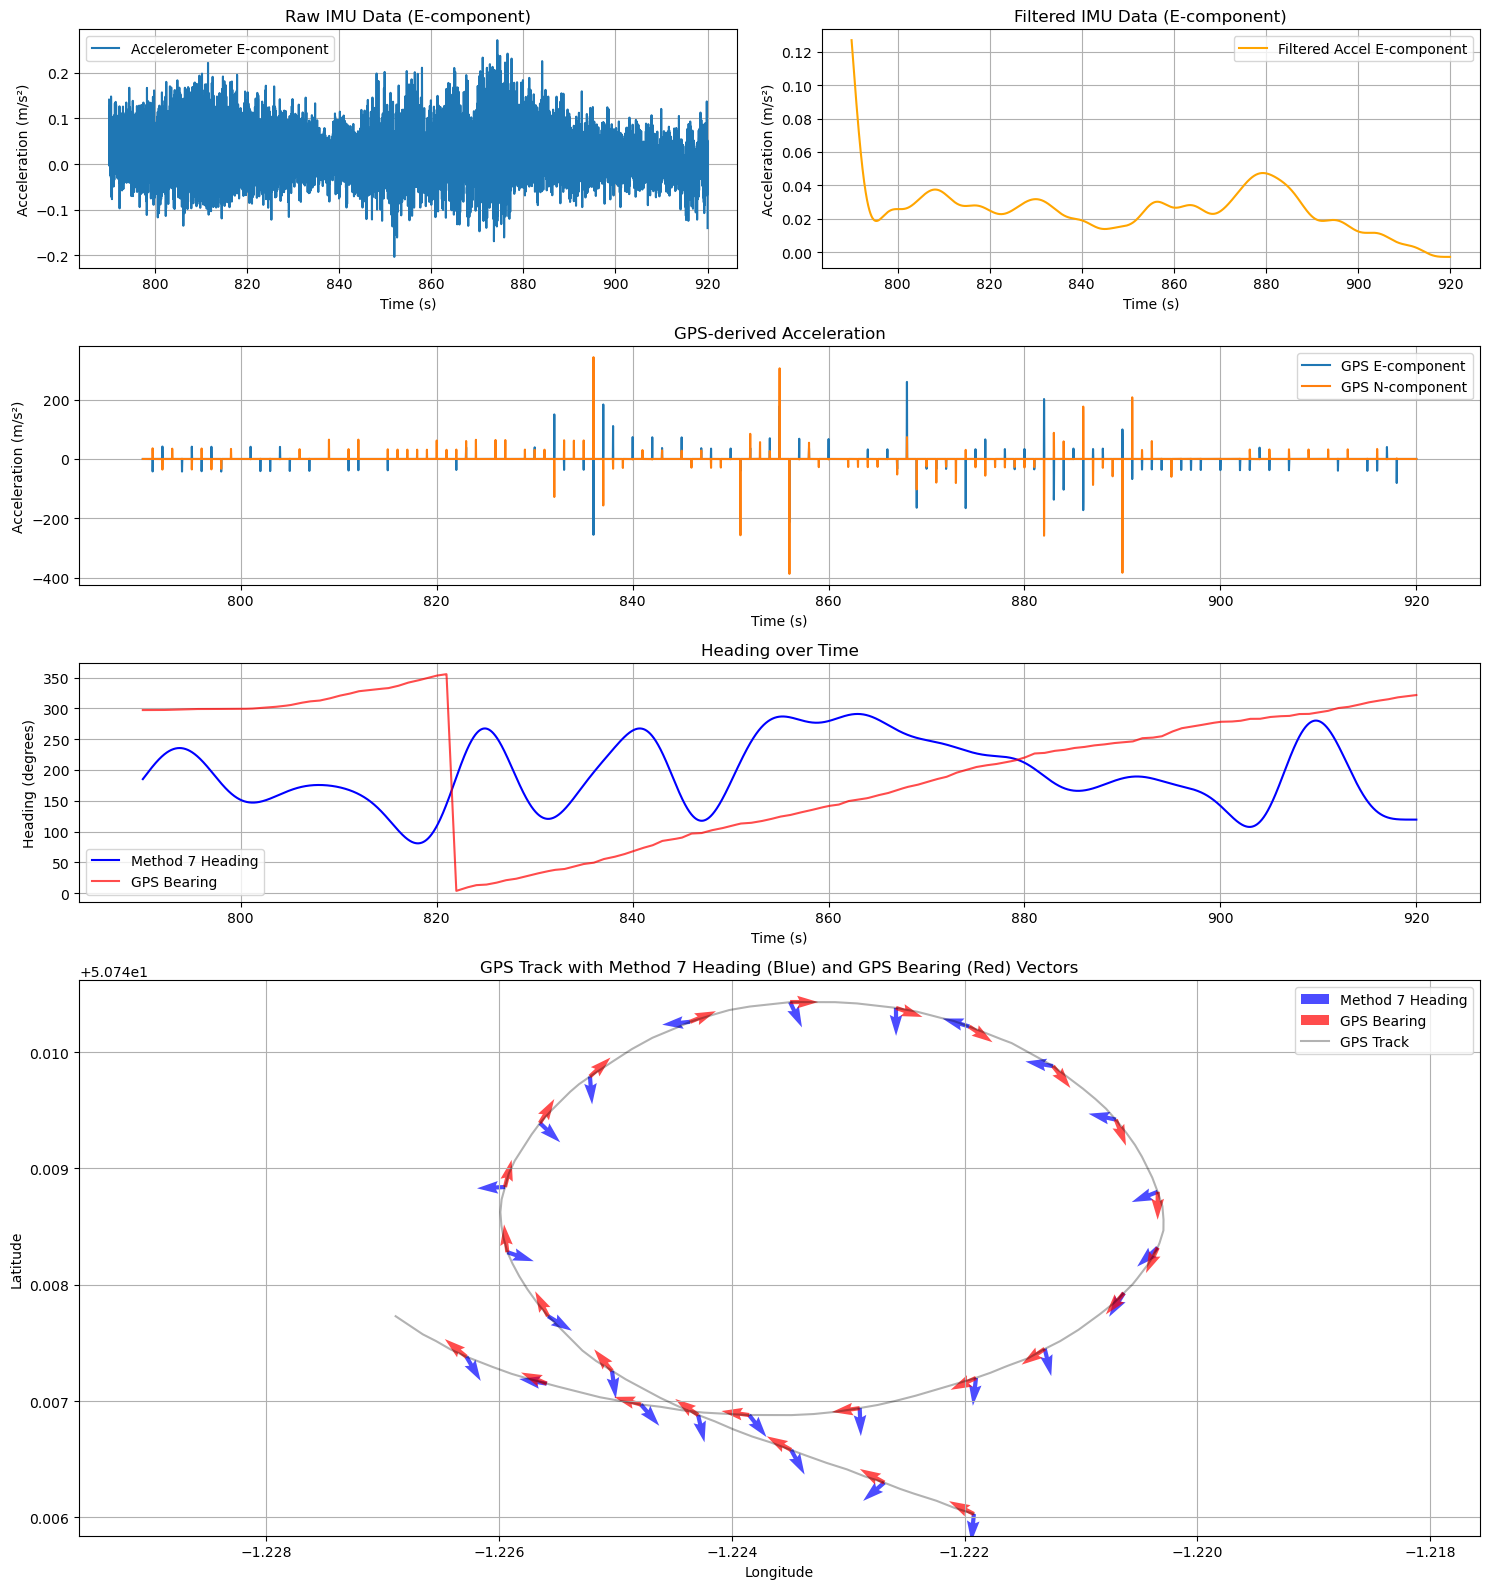

In [13]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
import pandas as pd
import os
import matplotlib.pyplot as plt
from ahrs.filters import Madgwick
from scipy.spatial.transform import Rotation as R

# === Quaternion Multiplication Function ===

def quaternion_multiply(q1, q2):
    """
    Multiply two quaternions.

    Parameters:
    - q1: First quaternion as a numpy array [w, x, y, z]
    - q2: Second quaternion as a numpy array [w, x, y, z]

    Returns:
    - Product quaternion as a numpy array [w, x, y, z]
    """
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

# === VehicleHeadingCalculator Class ===

class VehicleHeadingCalculator:
    def __init__(self, sample_rate=100):
        self.g = 9.81  # Gravity constant (m/s²)
        self.omega_earth = 7.2921e-5  # Earth's rotation rate (rad/s)
        self.sample_rate = sample_rate  # Sampling rate (Hz)
    
    def remove_gravity_coriolis(self, accel, lat, vel_e, vel_n):
        """Remove gravity and Coriolis effects from acceleration measurements."""
        # Calculate Coriolis acceleration
        omega_u = self.omega_earth * np.sin(np.radians(lat))
        
        a_cor_e = 2 * vel_n * omega_u
        a_cor_n = -2 * vel_e * omega_u
        
        # Remove gravity and Coriolis
        accel_corrected = accel.copy()
        accel_corrected[:, 0] -= a_cor_e  # East
        accel_corrected[:, 1] -= a_cor_n  # North
        accel_corrected[:, 2] += self.g    # Up (remove gravity)
        
        return accel_corrected
    
    def transform_body_to_ned(self, accel_body, quaternions):
        """Transform acceleration from body to NED frame using quaternions."""
        accel_ned = np.zeros_like(accel_body)
        for i in range(len(accel_body)):
            q = quaternions[i]
            # Convert quaternion to scipy Rotation object
            rotation = R.from_quat([q[1], q[2], q[3], q[0]])  # scipy expects [x, y, z, w]
            # Rotate acceleration vector
            accel_ned[i] = rotation.apply(accel_body[i])
        return accel_ned
    
    def calculate_gnss_acceleration(self, lat, lon, time):
        """Calculate Earth-fixed acceleration from GNSS measurements."""
        R_earth = 6371000  # Earth radius in meters
        
        # Convert to ECEF coordinates
        x = R_earth * np.cos(np.radians(lat)) * np.cos(np.radians(lon))
        y = R_earth * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
        
        # Calculate velocities
        vel_e = np.gradient(x, time)
        vel_n = np.gradient(y, time)
        
        # Calculate accelerations
        acc_e = np.gradient(vel_e, time)
        acc_n = np.gradient(vel_n, time)
        
        return np.column_stack((acc_e, acc_n)), np.column_stack((vel_e, vel_n))
    
    def compute_heading_method7(self, imu_data, gps_data):
        """Implement Method 7 for heading calculation."""
        # Process IMU data with Madgwick filter
        madgwick = Madgwick(sampleperiod=1/self.sample_rate)
        quaternions = np.zeros((len(imu_data['accel']), 4))
        quaternions[0] = np.array([1, 0, 0, 0])  # Initial quaternion
        
        for i in range(1, len(imu_data['accel'])):
            quaternions[i] = madgwick.updateIMU(
                quaternions[i-1],
                gyr=imu_data['gyro'][i],
                acc=imu_data['accel'][i]
                # mag=imu_data['mag'][i]  # Uncomment if using magnetometer
            )
        
        # Transform accelerations to NED frame
        accel_ned = self.transform_body_to_ned(imu_data['accel'], quaternions)
        
        # Calculate GNSS-derived acceleration and velocity
        gnss_acc, gnss_vel = self.calculate_gnss_acceleration(
            gps_data['lat'], 
            gps_data['lng'], 
            gps_data['time']
        )
        
        # Remove gravity and Coriolis effects
        accel_corrected = self.remove_gravity_coriolis(
            accel_ned,
            gps_data['lat'],
            gnss_vel[:, 0],
            gnss_vel[:, 1]
        )
        
        # Calculate heading using horizontal acceleration components
        heading = np.arctan2(accel_corrected[:, 0], accel_corrected[:, 1])
        heading_degrees = np.degrees(heading) % 360
        
        # Apply low-pass filter to smooth the heading
        b, a = butter(4, 0.1, btype='low', fs=self.sample_rate)
        heading_filtered = filtfilt(b, a, heading_degrees)
        
        return heading_filtered

# === Transformation Functions ===

def transform_accel_imu3(x, y, z):
    E = z
    N = y
    U = x
    return E, N, U

def transform_accel_imu4(x, y, z):
    E = -y
    N = z
    U = x
    return E, N, U

def transform_accel_wb(x, y, z):
    E = y
    N = x
    U = z
    return E, N, U

def resample_data(original_time, target_time, data):
    """Resample data from original_time to target_time."""
    if data.ndim == 1:
        interp_func = interp1d(original_time, data, kind='linear', axis=0, fill_value='extrapolate')
        resampled_data = interp_func(target_time)
    else:
        resampled_data = np.zeros((len(target_time), data.shape[1]))
        for i in range(data.shape[1]):
            interp_func = interp1d(original_time, data[:, i], kind='linear', axis=0, fill_value='extrapolate')
            resampled_data[:, i] = interp_func(target_time)
    return resampled_data

def read_imu_data(base_path, test_name):
    """Read and transform IMU data (accel, gyro, mag) from all sensors."""
    sensors = ['Sensor_3', 'Sensor_4', 'Sensor_wb']
    sensor_data_accel = []
    sensor_data_gyro = []
    sensor_data_mag = []
    min_time = float('inf')
    max_time = float('-inf')
    
    # First pass: determine common time range across all sensors and all data types
    for sensor in sensors:
        for data_type in ['accel', 'gyro', 'mag']:
            data_path = os.path.join(base_path, test_name, 'IMU', sensor, f'{data_type}_{test_name}.csv')
            if not os.path.isfile(data_path):
                print(f"Warning: {data_type} data file not found for {sensor}: {data_path}")
                continue
            data_df = pd.read_csv(data_path)
            if 'time_from_sync' not in data_df.columns:
                raise ValueError(f"'time_from_sync' column missing in {data_type} data for {sensor}.")
            time = data_df['time_from_sync'].values
            min_time = min(min_time, time[0])
            max_time = max(max_time, time[-1])

    # Create common time array
    target_freq = 100  # Hz
    duration = max_time - min_time
    num_samples = int(duration * target_freq)
    common_time = np.linspace(min_time, max_time, num_samples)
    
    # Second pass: resample accel, gyro, mag data for each sensor to common_time
    for sensor in sensors:
        for data_type in ['accel', 'gyro', 'mag']:
            data_path = os.path.join(base_path, test_name, 'IMU', sensor, f'{data_type}_{test_name}.csv')
            if not os.path.isfile(data_path):
                print(f"Warning: {data_type} data file not found for {sensor}: {data_path}")
                continue
            data_df = pd.read_csv(data_path)
            if 'x' not in data_df.columns or 'y' not in data_df.columns or 'z' not in data_df.columns:
                raise ValueError(f"'x', 'y', 'z' columns missing in {data_type} data for {sensor}.")
            
            # Extract x, y, z data
            x = data_df['x'].values
            y = data_df['y'].values
            z = data_df['z'].values
            
            # Transform data based on sensor type and data type
            if data_type == 'accel':
                if sensor == 'Sensor_3':
                    E, N, U = transform_accel_imu3(x, y, z)
                elif sensor == 'Sensor_4':
                    E, N, U = transform_accel_imu4(x, y, z)
                else:  # Sensor_wb
                    E, N, U = transform_accel_wb(x, y, z)
                transformed_data = np.column_stack((E, N, U))
                resampled_data = resample_data(original_time=data_df['time_from_sync'].values,
                                              target_time=common_time,
                                              data=transformed_data)
                sensor_data_accel.append(resampled_data)
            
            elif data_type == 'gyro':
                # Assuming gyro data needs similar transformations; adjust if different
                if sensor == 'Sensor_3':
                    E, N, U = transform_accel_imu3(x, y, z)
                elif sensor == 'Sensor_4':
                    E, N, U = transform_accel_imu4(x, y, z)
                else:  # Sensor_wb
                    E, N, U = transform_accel_wb(x, y, z)
                transformed_data = np.column_stack((E, N, U))
                resampled_data = resample_data(original_time=data_df['time_from_sync'].values,
                                              target_time=common_time,
                                              data=transformed_data)
                sensor_data_gyro.append(resampled_data)
            
            elif data_type == 'mag':
                # Magnetometer data may require different transformations; adjust if necessary
                if sensor == 'Sensor_3':
                    E, N, U = transform_accel_imu3(x, y, z)
                elif sensor == 'Sensor_4':
                    E, N, U = transform_accel_imu4(x, y, z)
                else:  # Sensor_wb
                    E, N, U = transform_accel_wb(x, y, z)
                transformed_data = np.column_stack((E, N, U))
                resampled_data = resample_data(original_time=data_df['time_from_sync'].values,
                                              target_time=common_time,
                                              data=transformed_data)
                sensor_data_mag.append(resampled_data)

    # Convert lists to numpy arrays
    sensor_data_accel = np.array(sensor_data_accel)  # Shape: (num_sensors * data_types, num_samples, 3)
    sensor_data_gyro = np.array(sensor_data_gyro)    # Shape: (num_sensors * data_types, num_samples, 3)
    sensor_data_mag = np.array(sensor_data_mag)      # Shape: (num_sensors * data_types, num_samples, 3)
    
    # Check if any data was loaded
    if sensor_data_accel.size == 0:
        raise ValueError("No accelerometer data loaded. Please check your file paths.")
    if sensor_data_gyro.size == 0:
        print("Warning: No gyroscope data loaded.")
    if sensor_data_mag.size == 0:
        print("Warning: No magnetometer data loaded.")
    
    # Average across sensors
    averaged_accel = np.mean(sensor_data_accel, axis=0)  # Shape: (num_samples, 3)
    
    if sensor_data_gyro.size != 0:
        averaged_gyro = np.mean(sensor_data_gyro, axis=0)    # Shape: (num_samples, 3)
    else:
        averaged_gyro = np.zeros_like(averaged_accel)        # Placeholder if no gyro data
    
    if sensor_data_mag.size != 0:
        averaged_mag = np.mean(sensor_data_mag, axis=0)      # Shape: (num_samples, 3)
    else:
        averaged_mag = np.zeros_like(averaged_accel)         # Placeholder if no mag data
    
    print(f"Averaged Accel shape: {averaged_accel.shape}")
    print(f"Averaged Gyro shape: {averaged_gyro.shape}")
    print(f"Averaged Mag shape: {averaged_mag.shape}")
    
    return {'time': common_time, 
            'accel': averaged_accel, 
            'gyro': averaged_gyro, 
            'mag': averaged_mag}

def preprocess_imu(accel_data):
    """Apply low-pass filter to reduce noise in accelerometer data."""
    # Apply low-pass filter to reduce noise
    b, a = butter(4, 0.1, btype='low', fs=100)
    filtered_accel = filtfilt(b, a, accel_data, axis=0)
    return filtered_accel

# === GPS Functions ===

def gps_acceleration(lat, lng, time):
    """Calculate GPS-derived acceleration."""
    R_earth = 6371000  # Earth radius in meters
    
    # Convert to ECEF coordinates
    x = R_earth * np.cos(np.radians(lat)) * np.cos(np.radians(lng))
    y = R_earth * np.cos(np.radians(lat)) * np.sin(np.radians(lng))
    
    # Calculate velocity and acceleration
    vel_e = np.gradient(x, time)
    vel_n = np.gradient(y, time)
    acc_e = np.gradient(vel_e, time)
    acc_n = np.gradient(vel_n, time)
    
    return np.column_stack((acc_e, acc_n))

def read_gps_data(base_path, test_name):
    """Read GPS data, including Bearing."""
    gps_path = os.path.join(base_path, test_name, 'GPS', f'GPS_{test_name}.csv')
    if not os.path.isfile(gps_path):
        raise FileNotFoundError(f"GPS data file not found: {gps_path}")
    gps_df = pd.read_csv(gps_path)
    required_columns = {'Lat', 'Lng', 'Bearing', 'time_from_sync'}
    if not required_columns.issubset(gps_df.columns):
        missing = required_columns - set(gps_df.columns)
        raise ValueError(f"Missing columns in GPS data: {missing}")
    return {
        'lat': gps_df['Lat'].values,
        'lng': gps_df['Lng'].values,
        'bearing': gps_df['Bearing'].values,  # Added 'Bearing'
        'time': gps_df['time_from_sync'].values
    }

# === Plotting Function ===

def plot_data(calculator, imu_data, gps_data, heading_filtered):
    """Plot IMU data, GPS acceleration, and heading results."""
    # Since GPS data is already resampled in main(), use it directly
    common_time = imu_data['time']
    gps_lat = gps_data['lat']
    gps_lng = gps_data['lng']
    gps_bearing = gps_data['bearing']
    
    # Compute GPS acceleration
    gps_acc = gps_acceleration(gps_lat, gps_lng, common_time)
    
    # Plotting
    fig = plt.figure(figsize=(15, 16))  # Increased height for better layout
    gs = plt.GridSpec(5, 2)  # Adjust grid to accommodate additional plots if needed

    # 1. Raw IMU Data (Accelerometer E-component)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(common_time, imu_data['accel'][:, 0], label='Accelerometer E-component')
    ax1.set_title('Raw IMU Data (E-component)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Acceleration (m/s²)')
    ax1.legend()
    ax1.grid(True)

    # 2. Filtered IMU Data (Accelerometer E-component)
    ax2 = fig.add_subplot(gs[0, 1])
    filtered_imu = preprocess_imu(imu_data['accel'])
    ax2.plot(common_time, filtered_imu[:, 0], color='orange', label='Filtered Accel E-component')
    ax2.set_title('Filtered IMU Data (E-component)') 
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Acceleration (m/s²)')
    ax2.legend()
    ax2.grid(True)

    # 3. GPS Acceleration
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(common_time, gps_acc[:, 0], label='GPS E-component')
    ax3.plot(common_time, gps_acc[:, 1], label='GPS N-component')
    ax3.set_title('GPS-derived Acceleration')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.legend()
    ax3.grid(True)

    # 4. Heading over time (Method 7 vs GPS Bearing)
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(common_time, heading_filtered, label='Method 7 Heading', color='blue')
    ax4.plot(common_time, gps_bearing, label='GPS Bearing', color='red', alpha=0.7)
    ax4.set_title('Heading over Time')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Heading (degrees)')
    ax4.legend()
    ax4.grid(True)

    # 5. Quiver plot with Method 7 Heading and GPS Bearing
    ax5 = fig.add_subplot(gs[3:, :])
    
    # Define desired interval in seconds
    interval_sec = 5  # Place an arrow every 5 seconds
    
    # Sampling frequency (Hz)
    fs = 100  # As defined in read_imu_data
    
    # Calculate the number of samples per interval
    n = int(fs * interval_sec)
    
    # Ensure n is at least 1 to avoid zero division
    n = max(n, 1)
    
    # Subsample the data
    subsample_indices = np.arange(0, len(common_time), n)
    subsample_lng = gps_lng[subsample_indices]
    subsample_lat = gps_lat[subsample_indices]
    subsample_heading = heading_filtered[subsample_indices]
    subsample_bearing = gps_bearing[subsample_indices]  # Subsample 'Bearing'
    
    # Convert headings to radians
    heading_rad = np.radians(subsample_heading)
    bearing_rad = np.radians(subsample_bearing)
    
    # Calculate u and v components for Method 7 heading (Blue arrows)
    u_heading = np.sin(heading_rad)  # East component
    v_heading = np.cos(heading_rad)  # North component

    # Calculate u and v components for GPS bearing (Red arrows)
    u_bearing = np.sin(bearing_rad)  # East component
    v_bearing = np.cos(bearing_rad)  # North component

    # Plot quiver for Method 7 heading (blue arrows)
    q1 = ax5.quiver(subsample_lng, subsample_lat, u_heading, v_heading,
                scale=50, width=0.003, color='blue', alpha=0.7, label='Method 7 Heading')

    # Plot quiver for GPS bearing (red arrows)
    q2 = ax5.quiver(subsample_lng, subsample_lat, u_bearing, v_bearing,
                scale=50, width=0.003, color='red', alpha=0.7, label='GPS Bearing')

    # Plot GPS track
    ax5.plot(gps_lng, gps_lat, 'k-', alpha=0.3, label='GPS Track')
    
    ax5.set_title('GPS Track with Method 7 Heading (Blue) and GPS Bearing (Red) Vectors')
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Latitude')
    ax5.axis('equal')
    ax5.legend()
    ax5.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    # Define base path and test name
    base_path = '../'  # Adjust as needed
    test_name = '007_Fast_stbd_turn_1'  # Example test name
    
    # Read IMU and GPS data
    imu_data = read_imu_data(base_path, test_name)  # Contains accel, gyro, mag
    gps_data = read_gps_data(base_path, test_name)
    
    # Resample GPS data to common_time
    common_time = imu_data['time']
    original_gps_time = gps_data['time']
    
    # Ensure that GPS time data covers the common_time range
    if original_gps_time[0] > common_time[0] or original_gps_time[-1] < common_time[-1]:
        print("Warning: GPS data time range does not fully cover IMU data time range. Extrapolation may occur.")
    
    gps_lat_resampled = resample_data(original_time=original_gps_time,
                                     target_time=common_time,
                                     data=gps_data['lat'])
    gps_lng_resampled = resample_data(original_time=original_gps_time,
                                     target_time=common_time,
                                     data=gps_data['lng'])
    gps_bearing_resampled = resample_data(original_time=original_gps_time,
                                         target_time=common_time,
                                         data=gps_data['bearing'])
    
    # Update GPS data with resampled values
    gps_data_resampled = {
        'lat': gps_lat_resampled,
        'lng': gps_lng_resampled,
        'bearing': gps_bearing_resampled,
        'time': common_time
    }
    
    print(f"Resampled GPS data shapes:")
    print(f"Lat: {gps_data_resampled['lat'].shape}")
    print(f"Lng: {gps_data_resampled['lng'].shape}")
    print(f"Bearing: {gps_data_resampled['bearing'].shape}")
    print(f"Time: {gps_data_resampled['time'].shape}")
    
    # Initialize VehicleHeadingCalculator
    calculator = VehicleHeadingCalculator(sample_rate=100)
    
    # Prepare IMU data for heading calculation
    # No need to preprocess separately since data is already averaged and resampled
    # Extract accel, gyro, mag
    accel = imu_data['accel']  # Shape: (num_samples, 3)
    gyro = imu_data['gyro']    # Shape: (num_samples, 3)
    mag = imu_data['mag']      # Shape: (num_samples, 3)
    
    imu_data_prepared = {
        'accel': accel,
        'gyro': gyro,
        'mag': mag
    }
    
    # Compute new heading using Method 7 with resampled GPS data
    heading_filtered = calculator.compute_heading_method7(imu_data_prepared, gps_data_resampled)
    
    # Plot the results
    plot_data(calculator, imu_data, gps_data_resampled, heading_filtered)

# === Entry Point ===
if __name__ == "__main__":
    main()


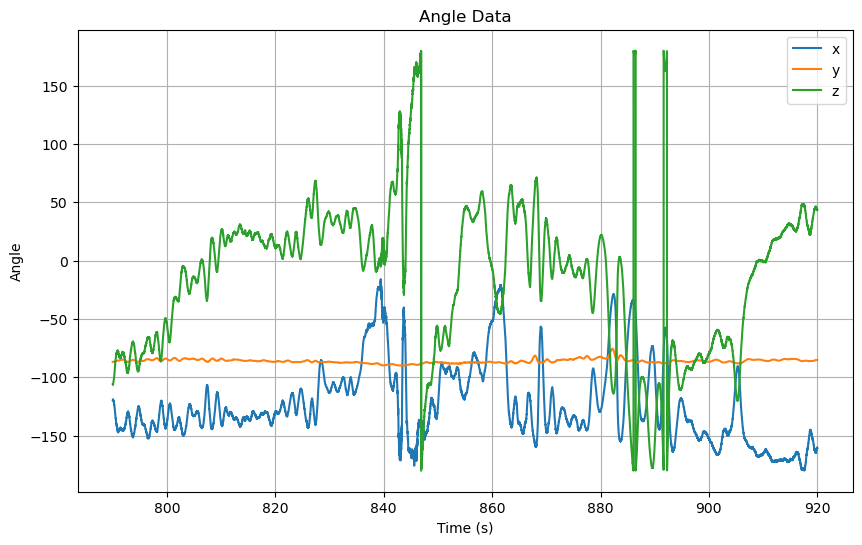

In [6]:
import pandas as pd

import matplotlib.pyplot as plt

# Read the angle data from the CSV file
df = pd.read_csv('./IMU/Sensor_4/angle_007_Fast_stbd_turn_1.csv')

# Plot x, y, and z angles against time_from_sync
plt.figure(figsize=(10, 6))
plt.plot(df['time_from_sync'], df['x'], label='x')
plt.plot(df['time_from_sync'], df['y'], label='y')
plt.plot(df['time_from_sync'], df['z'], label='z')
plt.xlabel('Time (s)')
plt.ylabel('Angle')
plt.title('Angle Data')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def calculate_heading_method7(imu_data, gps_data):
    def remove_gravity_coriolis(accel_data, lat, speed):
        # Constants
        g = 9.81  # m/s^2
        omega_earth = 7.2921e-5  # rad/s
        
        # Remove gravity
        accel_no_gravity = accel_data.copy()
        accel_no_gravity[:, 2] += g
        
        # Remove Coriolis effect
        # fcor = 2 * omega_earth * v * sin(lat) for horizontal components
        f_cor = 2 * omega_earth * speed * np.sin(np.radians(lat))
        accel_no_gravity[:, 0] -= f_cor * np.sin(np.radians(lat))
        
        return accel_no_gravity

    def transform_to_horizontal(accel_data):
        # Extract only horizontal components (E, N)
        return accel_data[:, :2]
    
    # 1. Preprocess IMU data
    combined_imu = preprocess_imu(imu_data['accel'])
    
    # 2. Remove gravity and Coriolis
    clean_accel = remove_gravity_coriolis(
        combined_imu,
        gps_data['lat'],
        gps_data['speed']  # Need to add speed to GPS data
    )
    
    # 3. Get horizontal components
    horizontal_accel = transform_to_horizontal(clean_accel)
    
    # 4. Calculate heading from horizontal acceleration
    # Heading = arctan2(ay, ax) converted to bearing convention
    heading = np.arctan2(horizontal_accel[:, 1], 
                        horizontal_accel[:, 0])
    heading_deg = (90 - np.degrees(heading)) % 360
    
    # 5. Apply low-pass filter for smoothing
    heading_smooth = smooth_heading(heading_deg)
    
    return heading_smooth


In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(
    filename='imu_data_plotting.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Define sensor types with full names, units, and ylabel templates
SENSOR_INFO = {
    'accel': {
        'full_name': 'Accelerometer',
        'unit': 'm/s²',
        'ylabel_template': 'Acceleration {axis} [{unit}]'
    },
    'gyro': {
        'full_name': 'Gyroscope',
        'unit': '°/s',
        'ylabel_template': 'Angular Velocity {axis} [{unit}]'
    },
    'mag': {
        'full_name': 'Magnetometer',
        'unit': 'µT',
        'ylabel_template': 'Magnetic Field {axis} [{unit}]'
    },
    'angle': {
        'full_name': 'Angle',
        'unit': '°',
        'ylabel_template': 'Angle {axis} [{unit}]'
    }
}

def plot_imu_data(experiment_path, sensor_info):
    """
    Processes and plots IMU data for a given experiment.

    Parameters:
    - experiment_path (str): Path to the experiment directory.
    - sensor_info (dict): Dictionary containing sensor labels and units.
    """
    imu_dir = os.path.join(experiment_path, 'IMU')
    if not os.path.isdir(imu_dir):
        logging.warning(f"IMU directory not found in {experiment_path}. Skipping this experiment.")
        return

    # Iterate through each sensor directory
    for sensor in os.listdir(imu_dir):
        sensor_path = os.path.join(imu_dir, sensor)
        if not os.path.isdir(sensor_path):
            logging.warning(f"{sensor_path} is not a directory. Skipping.")
            continue

        # Iterate through each data type
        for data_type, info in sensor_info.items():
            csv_filename = f"{data_type}_{os.path.basename(experiment_path)}.csv"
            csv_path = os.path.join(sensor_path, csv_filename)

            if not os.path.isfile(csv_path):
                logging.error(f"Missing file: {csv_path}. Skipping this file.")
                continue

            try:
                # Read the CSV file
                df = pd.read_csv(csv_path)
                logging.info(f"Successfully read {csv_path}.")
            except Exception as e:
                logging.error(f"Error reading {csv_path}: {e}. Skipping this file.")
                continue

            # Check if required columns exist
            required_columns = {'x', 'y', 'z', 'time_from_sync'}
            if not required_columns.issubset(df.columns):
                logging.error(f"Missing columns in {csv_path}. Required columns: {required_columns}. Skipping.")
                continue

            try:
                # Create a figure with three subplots for x, y, z
                fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
                fig.suptitle(
                    f"{info['full_name']} Data for {sensor} - {os.path.basename(experiment_path)}",
                    fontsize=18,
                    fontweight='bold'
                )

                axes_dict = {'x': axes[0], 'y': axes[1], 'z': axes[2]}
                axis_labels = {'x': 'X-axis', 'y': 'Y-axis', 'z': 'Z-axis'}

                for axis in ['x', 'y', 'z']:
                    axes_dict[axis].plot(
                        df['time_from_sync'],
                        df[axis],
                        label=axis_labels[axis],
                        color='b',
                        linewidth=1.5
                    )
                    # Update ylabel to include the axis name and unit
                    ylabel = info['ylabel_template'].format(axis=axis.upper(), unit=info['unit'])
                    axes_dict[axis].set_ylabel(ylabel, fontsize=12)
                    axes_dict[axis].tick_params(axis='both', which='major', labelsize=10)
                    axes_dict[axis].grid(True, linestyle='--', linewidth=0.5)

                axes[2].set_xlabel('Time from Sync (s)', fontsize=12)
                axes[2].tick_params(axis='both', which='major', labelsize=10)

                plt.tight_layout(rect=[0, 0.03, 1, 0.95])

                # Construct the plot filename
                experiment_name = os.path.basename(experiment_path)
                plot_filename = f"{experiment_name}_{sensor}_{data_type}.png"
                plot_path = os.path.join(sensor_path, plot_filename)  # Save in the sensor's folder

                # Save the plot with increased resolution
                plt.savefig(plot_path, dpi=300, bbox_inches='tight')
                # For vector format (optional), use the following line instead:
                # plt.savefig(plot_path.replace('.png', '.pdf'), format='pdf', bbox_inches='tight')
                plt.close(fig)
                logging.info(f"Saved plot: {plot_path}.")

            except Exception as e:
                logging.error(f"Error plotting data from {csv_path}: {e}. Skipping this file.")
                continue

def main():
    """
    Main function to process all experiments and plot their IMU data.
    """
    experiments_dir = "C:/Users/ben/Documents/EngD/09 Data collection/09 Data collection/2000TD Trials/Ryde-seatrials-afternoon-turns-12-12-2023/GPS/Experiments/"

    if not os.path.isdir(experiments_dir):
        logging.error(f"Experiments directory '{experiments_dir}' does not exist.")
        return

    experiments = os.listdir(experiments_dir)
    if not experiments:
        logging.warning(f"No experiments found in '{experiments_dir}'.")
        return

    for experiment in experiments:
        experiment_path = os.path.join(experiments_dir, experiment)
        if os.path.isdir(experiment_path):
            logging.info(f"Processing experiment: {experiment_path}")
            plot_imu_data(experiment_path, SENSOR_INFO)
        else:
            logging.warning(f"{experiment_path} is not a directory. Skipping.")

    logging.info("Completed processing all experiments.")

if __name__ == "__main__":
    main()


Heading not being calculated correctly

Uses only gps and no IMU data

Does heading make sense?

Plot the bearing angle over time and the heading over time to see at a quick check it they're roughly the same
The quiver plot should have the heading arrows all pointed inwards.

In [15]:
import pandas as pd
import numpy as np
import glob
import os
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# === Transformation Functions ===
def transform_accel_imu3(x, y, z):
    E = -z
    N = y
    U = x
    return E, N, U

def transform_accel_imu4(x, y, z):
    E = y
    N = z
    U = x
    return E, N, U

def transform_accel_wb(x, y, z):
    E = z
    N = -y
    U = x
    return E, N, U

# === Data Loading Functions ===
def load_and_transform_accel(sensor_path, sensor_name):
    accel_files = glob.glob(os.path.join(sensor_path, f"accel_*.csv"))
    if not accel_files:
        raise FileNotFoundError(f"No accelerometer files found for {sensor_name} in {sensor_path}")
    
    accel_df = pd.read_csv(accel_files[0])
    
    if sensor_name == 'Sensor_3':
        accel_df[['E', 'N', 'U']] = accel_df.apply(
            lambda row: pd.Series(transform_accel_imu3(row['x'], row['y'], row['z'])), axis=1)
    elif sensor_name == 'Sensor_4':
        accel_df[['E', 'N', 'U']] = accel_df.apply(
            lambda row: pd.Series(transform_accel_imu4(row['x'], row['y'], row['z'])), axis=1)
    elif sensor_name == 'Sensor_wb':
        accel_df[['E', 'N', 'U']] = accel_df.apply(
            lambda row: pd.Series(transform_accel_wb(row['x'], row['y'], row['z'])), axis=1)
    else:
        raise ValueError(f"Unknown sensor name: {sensor_name}")
    
    accel_df = accel_df[['time_from_sync', 'E', 'N', 'U']]
    accel_df.rename(columns={'E': f'E_{sensor_name}', 
                             'N': f'N_{sensor_name}', 
                             'U': f'U_{sensor_name}'}, inplace=True)
    return accel_df

def load_all_accel_data(base_path, experiment_folder):
    sensors = ['Sensor_3', 'Sensor_4', 'Sensor_wb']
    merged_accel = None
    for sensor in sensors:
        sensor_path = os.path.join(base_path, experiment_folder, 'IMU', sensor)
        accel_df = load_and_transform_accel(sensor_path, sensor)
        if merged_accel is None:
            merged_accel = accel_df
        else:
            merged_accel = pd.merge_asof(merged_accel.sort_values('time_from_sync'),
                                         accel_df.sort_values('time_from_sync'),
                                         on='time_from_sync',
                                         direction='nearest',
                                         tolerance=0.005)  # 5 ms tolerance
    return merged_accel

def load_gps_data(base_path, experiment_folder):
    gps_file = os.path.join(base_path, experiment_folder, 'GPS', f"GPS_{experiment_folder}.csv")
    if not os.path.exists(gps_file):
        raise FileNotFoundError(f"GPS file not found: {gps_file}")
    gps_df = pd.read_csv(gps_file)
    gps_df = gps_df[['time_from_sync', 'SpeedKPH', 'Bearing']]
    return gps_df

# === Data Processing Functions ===
def subtract_gravity(df):
    g = 9.81  # m/s^2
    stationary = df['SpeedKPH'] < 0.5  # Threshold for stationary
    gravity_estimate = df.loc[stationary, 'U_Sensor_3'].mean()
    df['U_Sensor_3_corrected'] = df['U_Sensor_3'] - gravity_estimate
    df['U_Sensor_4_corrected'] = df['U_Sensor_4'] - gravity_estimate
    df['U_Sensor_wb_corrected'] = df['U_Sensor_wb'] - gravity_estimate
    return df

def compute_horizontal_acceleration(df):
    df['E_avg'] = df[['E_Sensor_3', 'E_Sensor_4', 'E_Sensor_wb']].mean(axis=1)
    df['N_avg'] = df[['N_Sensor_3', 'N_Sensor_4', 'N_Sensor_wb']].mean(axis=1)
    return df

def compute_heading(df):
    df['Heading_accel'] = np.degrees(np.arctan2(df['E_avg'], df['N_avg'])) % 360
    return df

# === Visualization Function ===
def plot_heading(df):
    plt.figure(figsize=(14, 6))
    plt.plot(df['time_from_sync'], df['Heading_accel'], label='Heading from Acceleration', alpha=0.7)
    plt.plot(df['time_from_sync'], df['Bearing'], label='GPS Bearing', alpha=0.7)
    plt.xlabel('Time from Sync (s)')
    plt.ylabel('Heading (degrees)')
    plt.title('Hovercraft Heading: Acceleration-Based vs GPS Bearing')
    plt.legend()
    plt.grid(True)
    plt.show()

# === Main Execution ===
def main():
    base_path = '../'  # Replace with your base directory
    experiment_folder = '007_Fast_stbd_turn_1'
    
    # Load data
    accel_data = load_all_accel_data(base_path, experiment_folder)
    gps_data = load_gps_data(base_path, experiment_folder)
    
    # Merge data
    merged_data = pd.merge_asof(accel_data.sort_values('time_from_sync'),
                                gps_data.sort_values('time_from_sync'),
                                on='time_from_sync',
                                direction='nearest',
                                tolerance=0.005)  # 5 ms tolerance
    
    # Process data
    merged_data = subtract_gravity(merged_data)
    merged_data = compute_horizontal_acceleration(merged_data)
    merged_data = compute_heading(merged_data)
    
    # Plot results
    plot_heading(merged_data)

if __name__ == "__main__":
    main()


KeyboardInterrupt: 

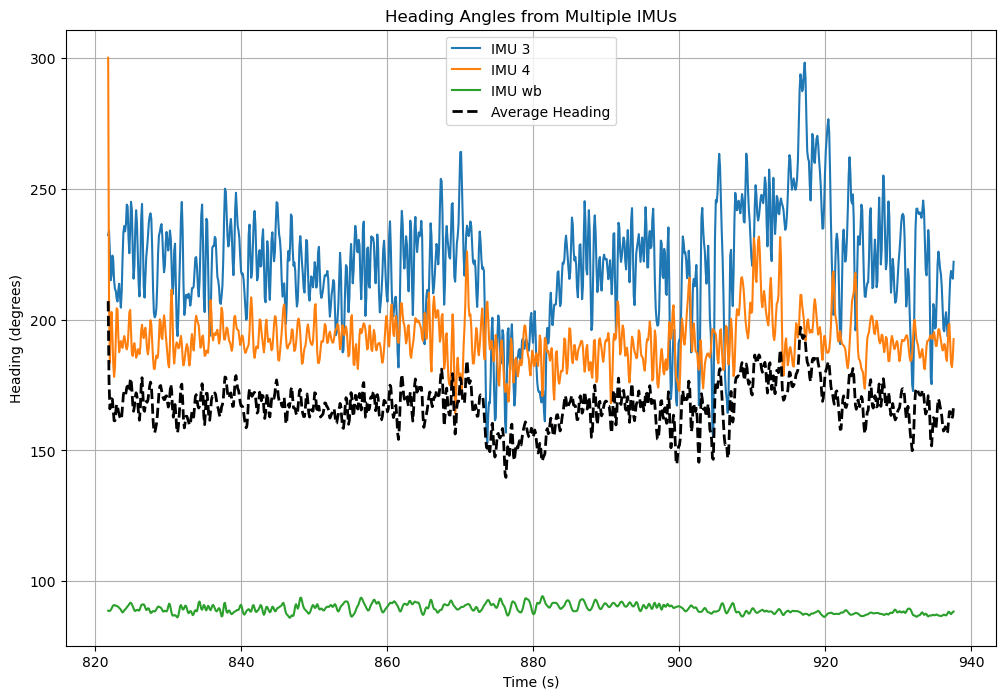

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d

def load_and_process_imu_data(base_path, sensor_name):
    # Load angle data
    angle_df = pd.read_csv(f"{base_path}/Sensor_{sensor_name}/angle_007_Fast_stbd_turn_1.csv")
    # Load acceleration data
    accel_df = pd.read_csv(f"{base_path}/Sensor_{sensor_name}/accel_007_Fast_stbd_turn_1.csv")
    
    return angle_df, accel_df

def transform_data(accel_data, transform_func):
    E, N, U = transform_func(accel_data['x'], accel_data['y'], accel_data['z'])
    return pd.DataFrame({'t': accel_data['t'], 'E': E, 'N': N, 'U': U})

def calculate_heading(angle_data, accel_data):
    roll = angle_data['x']
    pitch = angle_data['y']
    yaw = angle_data['z']
    
    roll_rad = np.radians(roll)
    pitch_rad = np.radians(pitch)
    yaw_rad = np.radians(yaw)
    
    heading = np.degrees(np.arctan2(accel_data['E'], accel_data['N']))
    heading = (heading + 360) % 360
    
    return heading

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def process_all_imus(base_path):
    transform_funcs = {
        '3': transform_accel_imu3,
        '4': transform_accel_imu4,
        'wb': transform_accel_wb
    }
    
    headings = {}
    time_series = {}
    
    # First pass: collect all time series and headings
    for sensor_name in transform_funcs.keys():
        angle_df, accel_df = load_and_process_imu_data(base_path, sensor_name)
        transformed_accel = transform_data(accel_df, transform_funcs[sensor_name])
        
        heading = calculate_heading(angle_df, transformed_accel)
        
        fs = 1 / (angle_df['t'].iloc[1] - angle_df['t'].iloc[0])
        filtered_heading = butter_lowpass_filter(heading, cutoff=2.0, fs=fs)
        
        headings[sensor_name] = filtered_heading
        time_series[sensor_name] = angle_df['t'].values

    # Create a common time base
    start_time = max(t[0] for t in time_series.values())
    end_time = min(t[-1] for t in time_series.values())
    common_time = np.linspace(start_time, end_time, 1000)  # 1000 points

    # Interpolate all headings to common time base
    interpolated_headings = {}
    for sensor_name in headings:
        interp_func = interp1d(time_series[sensor_name], headings[sensor_name])
        interpolated_headings[sensor_name] = interp_func(common_time)

    # Now we can safely calculate the average
    avg_heading = np.mean(list(interpolated_headings.values()), axis=0)
    
    return interpolated_headings, avg_heading, common_time

def plot_results(time, headings, avg_heading):
    plt.figure(figsize=(12, 8))
    
    for sensor_name, heading in headings.items():
        plt.plot(time, heading, label=f'IMU {sensor_name}')
    
    plt.plot(time, avg_heading, 'k--', linewidth=2, label='Average Heading')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Heading (degrees)')
    plt.title('Heading Angles from Multiple IMUs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
base_path = "./IMU"
headings, avg_heading, time = process_all_imus(base_path)
plot_results(time, headings, avg_heading)

Bearing Comparison:
                 time_from_sync    Bearing  Calculated_Bearing  \
1 1970-01-01 00:00:00.000000791  297.31705          296.283409   
2 1970-01-01 00:00:00.000000792  297.38605          302.299221   
3 1970-01-01 00:00:00.000000793  297.88830          296.283462   
4 1970-01-01 00:00:00.000000794  298.39542          297.780122   
5 1970-01-01 00:00:00.000000795  299.04540          302.299309   

   Bearing_Difference  
1            1.102641  
2            4.410921  
3            2.111958  
4            1.265278  
5            3.280179  

Summary Statistics of Bearing Differences:
count    128.000000
mean       9.266889
std        4.741845
min        0.018334
25%        5.987496
50%        9.445415
75%       12.339435
max       20.514183
Name: Bearing_Difference, dtype: float64

Detailed comparison saved to bearing_comparison.csv


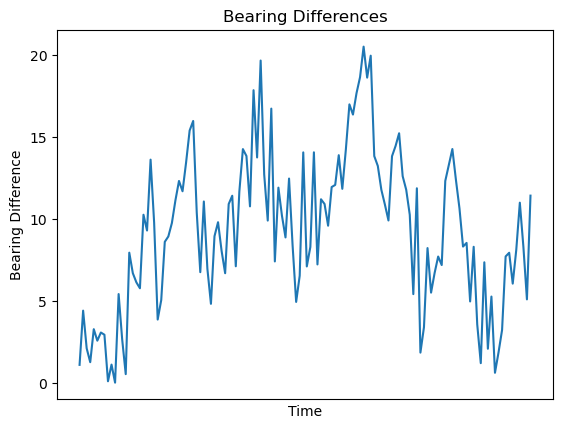

In [6]:
import pandas as pd
import numpy as np

# Function to calculate bearing between two points
def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate the bearing between two points on the Earth.
    Parameters:
        lat1, lon1: Latitude and Longitude of point 1 in decimal degrees
        lat2, lon2: Latitude and Longitude of point 2 in decimal degrees
    Returns:
        Bearing in degrees from point 1 to point 2
    """
    # Convert from degrees to radians
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    delta_lon = lon2_rad - lon1_rad
    x = np.sin(delta_lon) * np.cos(lat2_rad)
    y = (np.cos(lat1_rad) * np.sin(lat2_rad) -
         np.sin(lat1_rad) * np.cos(lat2_rad) * np.cos(delta_lon))
    
    initial_bearing = np.arctan2(x, y)
    # Convert from radians to degrees and normalize to 0-360
    initial_bearing_deg = (np.degrees(initial_bearing) + 360) % 360
    return initial_bearing_deg

# Path to your CSV file
csv_file_path = 'GPS/GPS_007_Fast_stbd_turn_1.csv'  # Replace with your actual file path

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Ensure the data is sorted by time. Adjust the 'Time' column format if necessary.
# Assuming 'Time' is in a format that pandas can parse
df['time_from_sync'] = pd.to_datetime(df['time_from_sync'])
df = df.sort_values('time_from_sync').reset_index(drop=True)

# Shift the latitude and longitude to get previous points
df['Prev_Lat'] = df['Lat'].shift(1)
df['Prev_Lng'] = df['Lng'].shift(1)

# Calculate the bearing from the previous point to the current point
df['Calculated_Bearing'] = calculate_bearing(
    df['Prev_Lat'],
    df['Prev_Lng'],
    df['Lat'],
    df['Lng']
)

# Since the first row has no previous point, it will have NaN
# Compare the calculated bearing to the recorded 'Bearing'
# Depending on the definition, you might need to shift 'Bearing' as well
# Here, we assume 'Bearing' at point i corresponds to movement from i to i+1
# So we compare 'Bearing' at i to 'Calculated_Bearing' at i+1

df['Bearing_Shifted'] = df['Bearing'].shift(-1)

# Calculate the difference
df['Bearing_Difference'] = (df['Calculated_Bearing'] - df['Bearing_Shifted']).abs()

# Adjust differences to be within [0, 180]
df['Bearing_Difference'] = df['Bearing_Difference'].apply(lambda x: min(x, 360 - x) if pd.notnull(x) else x)

# Display some comparison results
print("Bearing Comparison:")
print(df[['time_from_sync', 'Bearing', 'Calculated_Bearing', 'Bearing_Difference']].dropna().head())

# Summary statistics
print("\nSummary Statistics of Bearing Differences:")
print(df['Bearing_Difference'].describe())

# Optionally, save the comparison to a new CSV
output_file_path = 'bearing_comparison.csv'
df.to_csv(output_file_path, index=False)
print(f"\nDetailed comparison saved to {output_file_path}")

# Optionally, plot the differences
import matplotlib.pyplot as plt
plt.plot(df['time_from_sync'], df['Bearing_Difference'])
plt.xlabel('Time')
plt.ylabel('Bearing Difference')
plt.title('Bearing Differences')
plt.show()



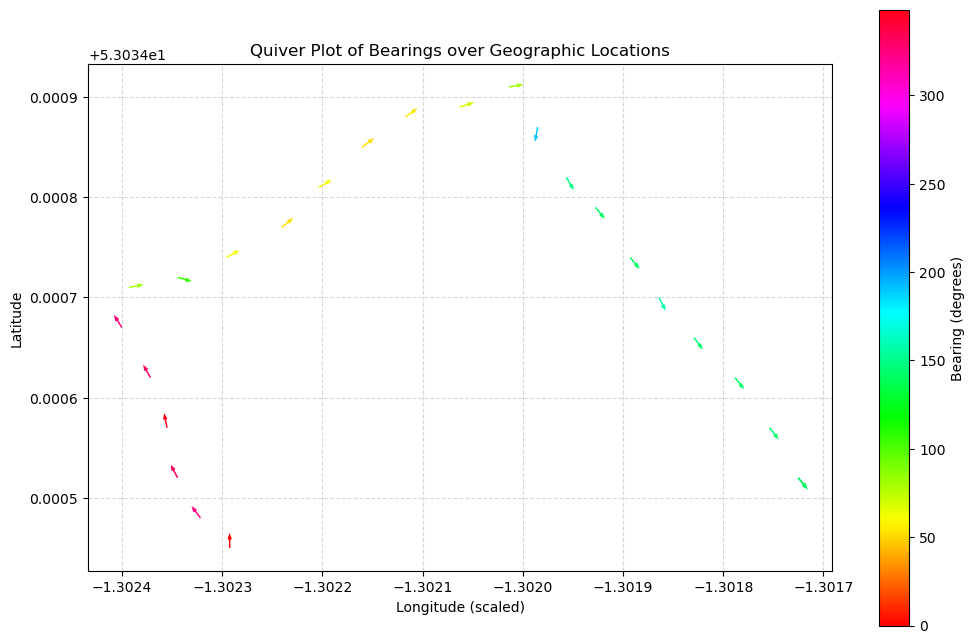

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to convert bearing to vector components
def bearing_to_vector(bearing_deg):
    """
    Convert bearing in degrees to vector components (u, v).
    Bearing is measured in degrees clockwise from North.
    """
    bearing_rad = np.deg2rad(bearing_deg)
    # Convert bearing to mathematical angle (counter-clockwise from East)
    angle_rad = np.pi/2 - bearing_rad
    angle_rad = np.mod(angle_rad, 2 * np.pi)
    u = np.cos(angle_rad)
    v = np.sin(angle_rad)
    return u, v

# Path to your CSV file
csv_file_path = '2024-11-04_161834_90_degrees_test.csv'  # Replace with your actual file path

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Optional: Sort the data by time to ensure chronological order
if 'Time' in df.columns:
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values('Time').reset_index(drop=True)

# Extract necessary columns
required_columns = ['Lat', 'Lng', 'Bearing']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Required column '{col}' not found in the CSV file.")

# Drop rows with missing values in required columns
df = df.dropna(subset=required_columns).reset_index(drop=True)

# Optional: Downsample the data for better visualization if the dataset is large
# For example, aim for around 1000 arrows
max_arrows = 1000
step = max(1, len(df) // max_arrows)
df_plot = df.iloc[::step, :]

# Convert bearing to vector components
u, v = bearing_to_vector(df_plot['Bearing'])

# Apply scaling to longitude to account for latitude
# This ensures that the horizontal scaling reflects actual distances
df_plot['Lng_scaled'] = df_plot['Lng'] * np.cos(np.deg2rad(df_plot['Lat']))

# Create the quiver plot
plt.figure(figsize=(12, 8))
quiver = plt.quiver(
    df_plot['Lng_scaled'], 
    df_plot['Lat'], 
    u, 
    v, 
    df_plot['Bearing'],
    cmap='hsv',
    scale=50,       # Adjust scale for arrow length
    width=0.002,    # Adjust width for arrow thickness
    headwidth=3,
    headlength=4
)

plt.xlabel('Longitude (scaled)')
plt.ylabel('Latitude')
plt.title('Quiver Plot of Bearings over Geographic Locations')

# Add a color bar to indicate bearing angles
cbar = plt.colorbar(quiver)
cbar.set_label('Bearing (degrees)')

# Set aspect ratio to equal to maintain correct scaling
plt.gca().set_aspect('equal', adjustable='box')

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()




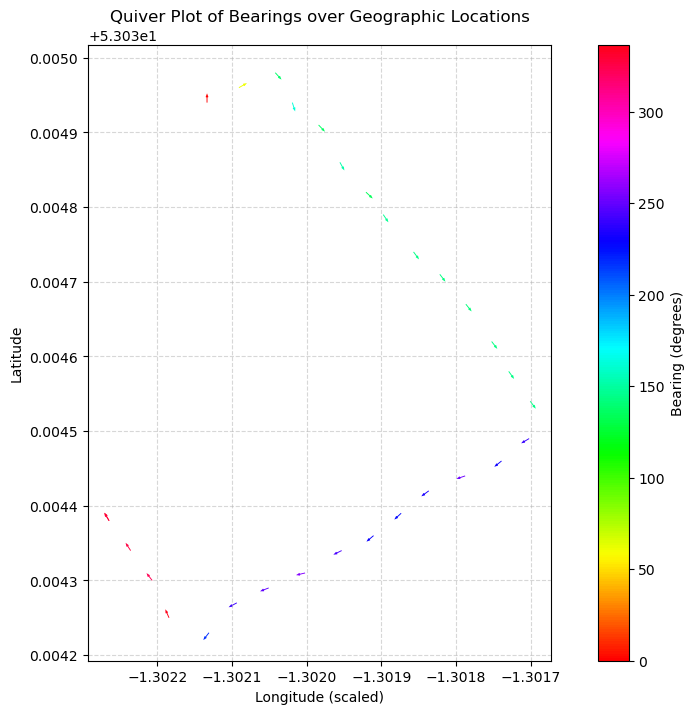

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to convert bearing to vector components
def bearing_to_vector(bearing_deg):
    """
    Convert bearing in degrees to vector components (u, v).
    Bearing is measured in degrees clockwise from North.
    """
    bearing_rad = np.deg2rad(bearing_deg)
    # Convert bearing to mathematical angle (counter-clockwise from East)
    angle_rad = np.pi/2 - bearing_rad
    angle_rad = np.mod(angle_rad, 2 * np.pi)
    u = np.cos(angle_rad)
    v = np.sin(angle_rad)
    return u, v

# Path to your CSV file
csv_file_path = '2024-11-04_161642_aligned_test.csv'  # Replace with your actual file path

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Optional: Sort the data by time to ensure chronological order
if 'Time' in df.columns:
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values('Time').reset_index(drop=True)

# Extract necessary columns
required_columns = ['Lat', 'Lng', 'Bearing']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Required column '{col}' not found in the CSV file.")

# Drop rows with missing values in required columns
df = df.dropna(subset=required_columns).reset_index(drop=True)

# Optional: Downsample the data for better visualization if the dataset is large
# For example, aim for around 1000 arrows
max_arrows = 1000
step = max(1, len(df) // max_arrows)
df_plot = df.iloc[::step, :]

# Convert bearing to vector components
u, v = bearing_to_vector(df_plot['Bearing'])

# Apply scaling to longitude to account for latitude
# This ensures that the horizontal scaling reflects actual distances
df_plot['Lng_scaled'] = df_plot['Lng'] * np.cos(np.deg2rad(df_plot['Lat']))

# Create the quiver plot
plt.figure(figsize=(12, 8))
quiver = plt.quiver(
    df_plot['Lng_scaled'], 
    df_plot['Lat'], 
    u, 
    v, 
    df_plot['Bearing'],
    cmap='hsv',
    scale=50,       # Adjust scale for arrow length
    width=0.002,    # Adjust width for arrow thickness
    headwidth=3,
    headlength=4
)

plt.xlabel('Longitude (scaled)')
plt.ylabel('Latitude')
plt.title('Quiver Plot of Bearings over Geographic Locations')

# Add a color bar to indicate bearing angles
cbar = plt.colorbar(quiver)
cbar.set_label('Bearing (degrees)')

# Set aspect ratio to equal to maintain correct scaling
plt.gca().set_aspect('equal', adjustable='box')

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()




In [24]:
import pandas as pd
import folium
from folium import plugins
import os
import glob
import math

def plot_gps_path(gps_file, wind_direction=None, wind_speed=None):
    # Load the CSV file
    df = pd.read_csv(gps_file)
    
    # Extract required columns
    df = df[['Lat', 'Lng', 'time_from_sync', 'Bearing', 'SpeedKPH']]
    
    # Sort by time_from_sync to ensure correct path order
    df = df.sort_values('time_from_sync')
    
    # Create a map centered on the mean coordinates
    m = folium.Map(location=[df['Lat'].mean(), df['Lng'].mean()], zoom_start=14)
    
    # Create a PolyLine of the path
    coordinates = df[['Lat', 'Lng']].values.tolist()
    folium.PolyLine(coordinates, weight=2, color='blue', opacity=0.8).add_to(m)
    
    # Add start and end markers
    folium.Marker(
        location=coordinates[0],
        popup='Start',
        icon=folium.Icon(color='green', icon='play')
    ).add_to(m)
    
    folium.Marker(
        location=coordinates[-1],
        popup='End',
        icon=folium.Icon(color='red', icon='stop')
    ).add_to(m)
    
    # Add arrows indicating bearing and speed every 10 points
    for i in range(0, len(df), 5):
        lat, lng = df.iloc[i]['Lat'], df.iloc[i]['Lng']
        bearing = df.iloc[i]['Bearing']
        speed = df.iloc[i]['SpeedKPH']
        
        # Calculate arrow endpoint based on speed and bearing
        arrow_length = speed * 0.00001  # Adjust this factor to scale arrow length
        end_lat = lat + arrow_length * math.cos(math.radians(bearing))
        end_lng = lng + arrow_length * math.sin(math.radians(bearing))
        
        folium.PolyLine(
            locations=[[lat, lng], [end_lat, end_lng]],
            color='red',
            weight=2,
            opacity=0.8,
            popup=f"Speed: {speed:.2f} km/h, Bearing: {bearing:.2f}°"
        ).add_to(m)
        
        # Add arrowhead
        folium.RegularPolygonMarker(
            location=[end_lat, end_lng],
            number_of_sides=3,
            rotation=bearing,
            radius=3,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.8
        ).add_to(m)
    
    # Add wind direction and speed marker if provided
    if wind_direction is not None and wind_speed is not None:
        # Adjust wind direction by 180 degrees
        adjusted_wind_direction = (wind_direction + 180) % 360
        wind_marker = folium.Marker(
            location=[df['Lat'].mean(), df['Lng'].mean()],
            icon=folium.Icon(color='blue', icon='arrow-up', prefix='fa', angle=adjusted_wind_direction),
            popup=f'Wind Direction: {wind_direction}°, Wind Speed: {wind_speed} km/h'
        )
        wind_marker.add_to(m)
    
    # Add fullscreen option
    plugins.Fullscreen().add_to(m)
    
    # Save the map
    m.save(f'gps_map_{os.path.basename(gps_file)}.html')

# Search for GPS CSV files
gps_files = glob.glob('**/GPS*.csv', recursive=True)

# Plot GPS path for each found file
for gps_file in gps_files:
    # You can now call plot_gps_path with or without wind data
    # Example with wind data:
    plot_gps_path(gps_file, wind_direction=229, wind_speed=21)
    # Example without wind data:
    # plot_gps_path(gps_file)

print(f"GPS maps have been created and saved for {len(gps_files)} files.")


GPS maps have been created and saved for 1 files.
